In [1]:
import numpy as np
import pandas as pd
from gurobipy import *

# For progress bar
# Instead of writing...
# > for i in some_list:
# You can write....
# > for i in tqdm(some_list):
# And you will get a very nice progress bar. This is very nice for 
# for-loops that run a long time, like running an optimization model for 
# many timesteps :)
from tqdm.auto import tqdm, trange  

# Plotting libaries - Feel free to use any others of your choice
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
style.use('fivethirtyeight')

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Haikun Huang, 391180

Ruixiang Wang, 400655

# HINT  
I recommend that you read through this notebook once *before* you start coding - you can do it all on your own but if you adhere to the structure that we hint at in this notebook, it might be easier for you

## Reading data  
This data is pretty clean but there are some surprises... I recommend that you re-index the dataframe with a [datetime-index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) since they have some very convienient attributes and methods which you will need (unless you want to put more effort into this).  
So for example the entries "01-01-2019", "00 - 01" should be changed so that this row has a datetime index "2019-01-01 00:00:00"

In [2]:
def read_ElspotPrices(filename):
    df = pd.read_html(filename, decimal=',', thousands='.', header = 2, match = 'Elspot Prices in EUR/MWh')
    df = df[0]
    df.rename( columns={'Unnamed: 0':'Dates'}, inplace=True )
    df['Hours'] = pd.Series(df['Hours'], dtype="string")
    df['Hours'] = df['Hours'].str.slice(0,3)
    df['Hours'] = df['Hours'] + '- 00'
    df['Hours'] = pd.Series(df['Hours'], dtype="object")
    df['Datetime'] = pd.to_datetime(df['Dates'] + ' ' + df['Hours'], format='%d-%m-%Y %H - %M')
    df = df.set_index('Datetime')
    df = df.drop(['Dates','Hours'], axis=1)
    df.dropna(axis=1, how='all', inplace=True)
    df.columns = df.columns.str.replace('.1', '')
    df.rename(columns={'S': 'SE1', 'D': 'DK1'}, inplace=True)
    return df # Returning a pandas dataframe

In [3]:
path = 'https://www.nordpoolgroup.com/4a05c7/globalassets/marketdata-excel-files/elspot-prices_2019_hourly_eur.xls'
df = read_ElspotPrices(path) # You can rename variables
df.columns

/Users/hhk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


Index(['SYS', 'SE1', 'SE2', 'SE3', 'SE4', 'FI', 'DK1', 'DK2', 'Oslo',
       'Kr.sand', 'Bergen', 'Molde', 'Tr.heim', 'TromsÃ¸', 'EE', 'LV', 'LT',
       'AT', 'BE', 'DE-LU', 'FR', 'NL'],
      dtype='object')

#### Daylight savings time  
The data from Elspot contains one hour twice and one hour is missing, thanks to daylight savings time. You have to convert the data so that the timezone is without daylight savings (so no hours exist twice or are missing).
You should also convert the data to UTC+0. The Nordpool headquarters are in norway (CET with summer time, so during the summer they have UTC+2 and during winter UTC+1). 
Below an example of the day light savings switch and how it should look like after you converted the time.  
Hint: You can use pandas functions for this, it can be done in three lines of code 

In [4]:
# Find the day light savings switch with duplicated datetime (clocks turned back for 1 hour)
# You can remove this cell if you want
timediffs = pd.Series(df.index).diff() # Calculate time difference between indices
daylight_idx = timediffs[timediffs == pd.Timedelta(0)].idxmax() #  Find row with no time-difference 
df[daylight_idx-2:daylight_idx+2] # Show the rows surrounding this row

,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,...,Tr.heim,TromsÃ¸,EE,LV,LT,AT,BE,DE-LU,FR,NL
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-10-27 01:00:00,33.84,31.68,31.68,31.68,31.68,31.68,27.11,27.11,37.12,37.12,...,31.68,31.68,31.68,31.68,31.68,32.01,26.30,-34.57,27.30,27.11
2019-10-27 02:00:00,33.43,31.46,31.46,31.46,31.46,31.46,9.04,9.04,37.11,37.11,...,31.46,31.46,31.46,31.46,31.46,31.07,14.25,-29.97,21.13,25.00
2019-10-27 02:00:00,33.18,31.49,31.49,31.49,31.49,31.49,0.05,0.05,37.11,37.11,...,31.49,31.49,31.49,31.49,31.49,31.05,25.81,-9.97,11.58,25.70
2019-10-27 03:00:00,33.05,31.12,31.12,31.12,31.12,31.12,0.12,0.12,37.08,37.08,...,31.36,31.36,31.12,31.12,31.12,31.04,22.76,0.12,14.03,22.86


In [5]:
def removeDaylightSavings(df):
    df.dropna(axis=0, how='all', inplace=True)
    df.index = df.index.tz_localize('Europe/Berlin', ambiguous = 'infer')
    df.index = df.index.tz_convert(None)
    return df

In [6]:
df = removeDaylightSavings(df)

In [7]:
# Show results
df[daylight_idx-2:daylight_idx+2]

,SYS,SE1,SE2,SE3,SE4,FI,DK1,DK2,Oslo,Kr.sand,...,Tr.heim,TromsÃ¸,EE,LV,LT,AT,BE,DE-LU,FR,NL
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-10-27 00:00:00,33.43,31.46,31.46,31.46,31.46,31.46,9.04,9.04,37.11,37.11,...,31.46,31.46,31.46,31.46,31.46,31.07,14.25,-29.97,21.13,25.00
2019-10-27 01:00:00,33.18,31.49,31.49,31.49,31.49,31.49,0.05,0.05,37.11,37.11,...,31.49,31.49,31.49,31.49,31.49,31.05,25.81,-9.97,11.58,25.70
2019-10-27 02:00:00,33.05,31.12,31.12,31.12,31.12,31.12,0.12,0.12,37.08,37.08,...,31.36,31.36,31.12,31.12,31.12,31.04,22.76,0.12,14.03,22.86
2019-10-27 03:00:00,33.32,31.66,31.66,31.66,31.66,31.66,5.50,5.50,37.00,37.00,...,31.66,31.66,31.66,31.66,31.66,31.03,16.41,5.50,12.90,16.47


This is how your data should be formated that you use as input for the "prediction generator":  
* pd.Series() containing the prices for your market area
* index should be of type datetime -> This will make it much easier to create your plots later

In [8]:
example = df["SE1"]
example

Datetime
2018-12-31 23:00:00    28.32
2019-01-01 00:00:00    10.07
2019-01-01 01:00:00    10.03
2019-01-01 02:00:00     4.56
2019-01-01 03:00:00     4.83
                       ...  
2019-12-31 18:00:00    32.37
2019-12-31 19:00:00    31.23
2019-12-31 20:00:00    31.33
2019-12-31 21:00:00    31.46
2019-12-31 22:00:00    30.83
Name: SE1, Length: 8760, dtype: float64

In [9]:
df.index

DatetimeIndex(['2018-12-31 23:00:00', '2019-01-01 00:00:00',
               '2019-01-01 01:00:00', '2019-01-01 02:00:00',
               '2019-01-01 03:00:00', '2019-01-01 04:00:00',
               '2019-01-01 05:00:00', '2019-01-01 06:00:00',
               '2019-01-01 07:00:00', '2019-01-01 08:00:00',
               ...
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00',
               '2019-12-31 21:00:00', '2019-12-31 22:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=8760, freq=None)

## "Predicting" future prices  
Since this is not a data science course, we will compare two very simple "prediction" methods:  
1) We perfectly know future prices  
2) Assume price will be the same as last weeks price at the same time  
  
If you want, you can also implement more elaborate prediction methods - you may be able to beat the results from 2) but you should not be able to beat 1)   
In case you implement another predictor, you should obviously only use the prices up to t-1 to predict prices for t to t + n :)

In [10]:
# You do not have to touch this code
class PredictionGenerator():
    def __init__(self, timeseries, method="perfect"):
        self.setMethod(method)
        self.df = timeseries

    # If you use more elaborate prediction methods, you might have to fit a model to the data
    # Implementing another prediction method will not better your grade, so ignore this if you want.
    def fit(self, end_date):
        pass

    # "Predict" prices for some date range defined by a start date and a number of hours
    def predict(self, start_date, nhours):
        dates = pd.date_range(
            start=start_date,
            periods=nhours,
            freq="H")

        if self.method == "Perfect":
            if dates.max() not in self.df.index: # check if prices known
                raise Exception(("You can not forecast the *future* perfectly "
                                 "out of sample! Some of the dates requested "
                                 "are not in the given dataset."))
            result = self.df.loc[dates]  # the actual observed prices
        elif self.method == "SameHourLastWeek":
            min_date = (dates.min() + pd.DateOffset(hours=-7*24))
            max_date = (dates.max() + pd.DateOffset(hours=-7*24))
            if (min_date not in self.df.index) or (max_date not in self.df.index):
                raise Exception(("For some of the dates you tried to predict, "
                                 "there is no data from the week before available."))
            # Last weeks prices
            result = self.df.loc[dates + pd.DateOffset(hours=-7*24)]
            result.index = dates
            
        return result

    
    # Set method if known, otherwise raise exception
    def setMethod(self, method):
        methods = ["Perfect", "SameHourLastWeek"]
        if method not in methods:
            raise Exception(f"Method passed({method}) is not in ["
                            + ", ".join(methods) + "]")
        self.method = method

In [11]:
# Example how to use:
# Create predictor
prediction_method = "SameHourLastWeek" # methods = ["Perfect", "SameHourLastWeek"]
prices = df["SE1"] # All prices that we have for the market area of interest as a Series
predictor = PredictionGenerator(prices, method=prediction_method)
# "Predict" prices for some time frame
t_start = pd.Timestamp("2019-10-22 00:00:00")
predicted_prices = predictor.predict(t_start, 10) # returns a series of "predicted" prices
                                                  # for the 10 hours starting on t_start

## The gurobi model  

In [12]:
def solve(prices,
          Pmax,
          Emax,
          E0,
          print_result=False):
    
    model = Model("Aluminum DSM")
    model.modelSense = GRB.MINIMIZE
    
    # If you test the model for one timestep, you probably want the usual gurobi
    # output, but if you run this model a lot (for every time-step...) this will
    # spam your output window, so i recommend to set print_result=False
    if not print_result:
        model.setParam('OutputFlag', False)

    Times = prices.index

    # Power deviation from nominal
    delta_P = {}
    for t in Times:
        delta_P[t] = model.addVar(
            name="delta_P_%s" % (t), 
            lb = -Pmax,
            ub = Pmax, 
            vtype = GRB.CONTINUOUS
        )

    # Energy deviation from nominal
    delta_E = {}
    for t in Times:
        delta_E[t] = model.addVar(
            name="delta_E_%s" % (t),
            lb = -Emax,
            ub = Emax, 
            vtype = GRB.CONTINUOUS
        )

    # # Maximum power difference
    # for t in Times:
    #     model.addConstr(-Pmax <= delta_P[t])
    #     model.addConstr(delta_P[t] <= Pmax)

    # # Maximum energy difference
    # for t in Times:
    #     model.addConstr(-Emax <= delta_E[t])
    #     model.addConstr(delta_E[t] <= Emax)

    # Energy balance
    for num_t in range(len(Times)):
        if num_t != 0:
            model.addConstr(delta_E[Times[num_t]] == 
                            delta_E[Times[num_t - 1]] + delta_P[Times[num_t]] * 1)

    # Energy at t = tau is given
    model.addConstr(delta_E[Times[0]] == 
                    E0 + delta_P[Times[0]] * 1)

    # No energy difference at last time step
    model.addConstr(delta_E[Times[-1]] == 0)

    # Obj function
    model.setObjective(
        quicksum( prices[t] * delta_P[t] * 1 for t in Times)
    )

    model.update()
    model.optimize()

    result_P = {}
    result_E = {}
    for t in Times:
        result_P[t] = float(delta_P[t].x)
        result_E[t] = float(delta_E[t].x)
    
    # In tutor you have to return the model, but in the notebook
    # you can also return something different (like P, E for all timesteps)
    return result_P, result_E

# Running your scenario  
The following cell is just to show you how to use tqdm for a progress bar, you can delete that cell and write the code to run the scenario how you want :)

In [13]:
def runScenario(historic_prices,             # Historic electricty prices
                E0, Emax, Pmax,              # Plant parameters
                prediction_method,           # Prediction settings
                t_start, t_end, t_horizon):  # Simulation times

    # You probably have to prepare some stuff here
    datetime = pd.date_range(t_start, t_end, freq="H")
    results = pd.DataFrame({'Datetime': datetime})
    results['Pt'] = np.nan
    results['Et'] = np.nan
    results['Et_first'] = np.nan
    results['current_price'] = historic_prices[datetime].to_list()
    results['predicted_price'] = np.nan
    results['cummulative_earnings'] = np.nan
    results = results.set_index('Datetime')
    
    for t in tqdm(pd.date_range(t_start, t_end, freq="H")):
        
        # Prepare price data for model

        # check t + t_horizon > t_end
        if t + pd.Timedelta(t_horizon, 'H') > t_end:
            diff_hours = (t + pd.Timedelta(t_horizon, 'H') - t_end).total_seconds()/ (60 * 60)
            t_hours = t_horizon - diff_hours
            if t_hours == 0:
                t_hours = 1
        else:
            t_hours = t_horizon

        # "Predict" prices
        predictor = PredictionGenerator(historic_prices, method=prediction_method)
        predicted_prices = predictor.predict(t, t_hours)
        pred_price = predicted_prices[t]
        predicted_prices.loc[t] = historic_prices[t]

        # Run model & save results for current timestep
        P_iter, E_iter = solve(predicted_prices, Pmax, Emax, E0, print_result=False)
        results.loc[t,'Pt'] = P_iter[t]
        results.loc[t,'Et'] = E_iter[t]
        results.loc[t,'predicted_price'] = pred_price
        if t == t_start:
            for t_key in E_iter.keys():
                results.loc[t_key,'Et_first'] = E_iter[t_key]

        earnings = 0
        for iter_t in pd.date_range(t_start, t, freq="H"):
            earnings = earnings - results.loc[iter_t, 'current_price'] * results.loc[iter_t, 'Pt'] * 1

        results.loc[t, 'cummulative_earnings'] = earnings

        # "Update world state":
        # - Set E0 based on optimization results for current time step
        E0 = E0 + P_iter[t] * 1
     
        # Write current results to console
        tqdm.write("%s: P = %s, E = %s, earnings = %s" % (t, P_iter[t], E0, earnings))
        
    return results # I recommend storing your results in a dataframe as well, for easier plotting

In [14]:
# Get data
market_area = "SE1"
historic_prices = df[market_area]

# Plant parameters
E0 = 0                                   # Energy difference at t = t_start
Pmax = 100                               # Maximum power deviation in MW
Emax = 48 * Pmax                         # Maximum energy deviation in MWh

# Simulation parameters
t_start = pd.Timestamp("2019-10-22 00:00:00") # Times are in UTC+0
t_end = pd.Timestamp("2019-12-22 00:00:00")  # Simulate two months of operation
t_horizon = 7*24                             # Time horizon for optimization (in h)

In [15]:
# Run your scenario :D
results_perfect = runScenario(historic_prices, E0, Emax, Pmax, 'Perfect', t_start, t_end, t_horizon)
results_lastWeek = runScenario(historic_prices, E0, Emax, Pmax, 'SameHourLastWeek', t_start, t_end, t_horizon)

  0%|          | 0/1465 [00:00<?, ?it/s]

Academic license - for non-commercial use only - expires 2021-08-02
Using license file /Users/hhk/gurobi.lic
2019-10-22 00:00:00: P = 100.0, E = 100.0, earnings = -3381.0
2019-10-22 01:00:00: P = 100.0, E = 200.0, earnings = -6565.0
2019-10-22 02:00:00: P = 100.0, E = 300.0, earnings = -9934.0
2019-10-22 03:00:00: P = 100.0, E = 400.0, earnings = -13392.0
2019-10-22 04:00:00: P = 100.0, E = 500.0, earnings = -16963.0
2019-10-22 05:00:00: P = -100.0, E = 400.0, earnings = -13285.0
2019-10-22 06:00:00: P = -100.0, E = 300.0, earnings = -9564.0
2019-10-22 07:00:00: P = -100.0, E = 200.0, earnings = -5891.0
2019-10-22 08:00:00: P = -100.0, E = 100.0, earnings = -2248.0
2019-10-22 09:00:00: P = 100.0, E = 200.0, earnings = -5826.0
2019-10-22 10:00:00: P = 100.0, E = 300.0, earnings = -9378.0
2019-10-22 11:00:00: P = 100.0, E = 400.0, earnings = -12866.0
2019-10-22 12:00:00: P = 100.0, E = 500.0, earnings = -16332.0
2019-10-22 13:00:00: P = 100.0, E = 600.0, earnings = -19803.0
2019-10-22 14

2019-10-27 08:00:00: P = 100.0, E = 4100.0, earnings = -91204.0
2019-10-27 09:00:00: P = 100.0, E = 4200.0, earnings = -94874.0
2019-10-27 10:00:00: P = 100.0, E = 4300.0, earnings = -98540.0
2019-10-27 11:00:00: P = 100.0, E = 4400.0, earnings = -102160.0
2019-10-27 12:00:00: P = 100.0, E = 4500.0, earnings = -105764.0
2019-10-27 13:00:00: P = 100.0, E = 4600.0, earnings = -109401.0
2019-10-27 14:00:00: P = 100.0, E = 4700.0, earnings = -113115.0
2019-10-27 15:00:00: P = -100.0, E = 4600.0, earnings = -109266.0
2019-10-27 16:00:00: P = -100.0, E = 4500.0, earnings = -105214.0
2019-10-27 17:00:00: P = -100.0, E = 4400.0, earnings = -101108.0
2019-10-27 18:00:00: P = -100.0, E = 4300.0, earnings = -97075.0
2019-10-27 19:00:00: P = -100.0, E = 4200.0, earnings = -93223.0
2019-10-27 20:00:00: P = -100.0, E = 4100.0, earnings = -89465.0
2019-10-27 21:00:00: P = 100.0, E = 4200.0, earnings = -93120.0
2019-10-27 22:00:00: P = 100.0, E = 4300.0, earnings = -96623.0
2019-10-27 23:00:00: P = 10

2019-11-01 17:00:00: P = -100.0, E = 300.0, earnings = 78857.0
2019-11-01 18:00:00: P = 100.0, E = 400.0, earnings = 75034.0
2019-11-01 19:00:00: P = 100.0, E = 500.0, earnings = 71303.0
2019-11-01 20:00:00: P = 100.0, E = 600.0, earnings = 67677.0
2019-11-01 21:00:00: P = 100.0, E = 700.0, earnings = 64273.0
2019-11-01 22:00:00: P = 100.0, E = 800.0, earnings = 61195.0
2019-11-01 23:00:00: P = 100.0, E = 900.0, earnings = 58045.0
2019-11-02 00:00:00: P = 100.0, E = 1000.0, earnings = 55038.0
2019-11-02 01:00:00: P = 100.0, E = 1100.0, earnings = 52237.0
2019-11-02 02:00:00: P = 100.0, E = 1200.0, earnings = 49537.0
2019-11-02 03:00:00: P = 100.0, E = 1300.0, earnings = 46731.0
2019-11-02 04:00:00: P = 100.0, E = 1400.0, earnings = 43721.0
2019-11-02 05:00:00: P = 100.0, E = 1500.0, earnings = 40278.0
2019-11-02 06:00:00: P = 100.0, E = 1600.0, earnings = 36708.0
2019-11-02 07:00:00: P = 100.0, E = 1700.0, earnings = 33049.0
2019-11-02 08:00:00: P = 100.0, E = 1800.0, earnings = 29254.

2019-11-07 02:00:00: P = 100.0, E = 2600.0, earnings = 55085.0
2019-11-07 03:00:00: P = -100.0, E = 2500.0, earnings = 59296.0
2019-11-07 04:00:00: P = -100.0, E = 2400.0, earnings = 63602.0
2019-11-07 05:00:00: P = -100.0, E = 2300.0, earnings = 68170.0
2019-11-07 06:00:00: P = -100.0, E = 2200.0, earnings = 73560.0
2019-11-07 07:00:00: P = -100.0, E = 2100.0, earnings = 79425.0
2019-11-07 08:00:00: P = -100.0, E = 2000.0, earnings = 84712.0
2019-11-07 09:00:00: P = -100.0, E = 1900.0, earnings = 89661.0
2019-11-07 10:00:00: P = -100.0, E = 1800.0, earnings = 94450.0
2019-11-07 11:00:00: P = -100.0, E = 1700.0, earnings = 99165.0
2019-11-07 12:00:00: P = -100.0, E = 1600.0, earnings = 103848.0
2019-11-07 13:00:00: P = -100.0, E = 1500.0, earnings = 108521.0
2019-11-07 14:00:00: P = -100.0, E = 1400.0, earnings = 113263.0
2019-11-07 15:00:00: P = -100.0, E = 1300.0, earnings = 118251.0
2019-11-07 16:00:00: P = -100.0, E = 1200.0, earnings = 123494.0
2019-11-07 17:00:00: P = -100.0, E =

2019-11-12 13:00:00: P = -100.0, E = -300.0, earnings = 225165.0
2019-11-12 14:00:00: P = -100.0, E = -400.0, earnings = 229563.0
2019-11-12 15:00:00: P = -100.0, E = -500.0, earnings = 233980.0
2019-11-12 16:00:00: P = -100.0, E = -600.0, earnings = 238313.0
2019-11-12 17:00:00: P = -100.0, E = -700.0, earnings = 242621.0
2019-11-12 18:00:00: P = -100.0, E = -800.0, earnings = 246823.0
2019-11-12 19:00:00: P = -100.0, E = -900.0, earnings = 250978.0
2019-11-12 20:00:00: P = 100.0, E = -800.0, earnings = 246883.0
2019-11-12 21:00:00: P = 100.0, E = -700.0, earnings = 242881.0
2019-11-12 22:00:00: P = 100.0, E = -600.0, earnings = 239117.0
2019-11-12 23:00:00: P = 100.0, E = -500.0, earnings = 235633.0
2019-11-13 00:00:00: P = 100.0, E = -400.0, earnings = 232150.0
2019-11-13 01:00:00: P = 100.0, E = -300.0, earnings = 228649.0
2019-11-13 02:00:00: P = 100.0, E = -200.0, earnings = 225127.0
2019-11-13 03:00:00: P = 100.0, E = -100.0, earnings = 221324.0
2019-11-13 04:00:00: P = 100.0, E

2019-11-17 22:00:00: P = 100.0, E = 100.0, earnings = 238147.0
2019-11-17 23:00:00: P = 100.0, E = 200.0, earnings = 234354.0
2019-11-18 00:00:00: P = 100.0, E = 300.0, earnings = 230630.0
2019-11-18 01:00:00: P = 100.0, E = 400.0, earnings = 226949.0
2019-11-18 02:00:00: P = 100.0, E = 500.0, earnings = 223261.0
2019-11-18 03:00:00: P = 100.0, E = 600.0, earnings = 219394.0
2019-11-18 04:00:00: P = 100.0, E = 700.0, earnings = 215403.0
2019-11-18 05:00:00: P = -100.0, E = 600.0, earnings = 219537.0
2019-11-18 06:00:00: P = -100.0, E = 500.0, earnings = 223851.0
2019-11-18 07:00:00: P = -100.0, E = 400.0, earnings = 228291.0
2019-11-18 08:00:00: P = -100.0, E = 300.0, earnings = 232780.0
2019-11-18 09:00:00: P = -100.0, E = 200.0, earnings = 237226.0
2019-11-18 10:00:00: P = -100.0, E = 100.0, earnings = 241623.0
2019-11-18 11:00:00: P = -100.0, E = 0.0, earnings = 246002.0
2019-11-18 12:00:00: P = -100.0, E = -100.0, earnings = 250359.0
2019-11-18 13:00:00: P = -100.0, E = -200.0, ear

2019-11-23 07:00:00: P = 100.0, E = -1600.0, earnings = 346364.0
2019-11-23 08:00:00: P = 100.0, E = -1500.0, earnings = 342498.0
2019-11-23 09:00:00: P = 100.0, E = -1400.0, earnings = 338583.0
2019-11-23 10:00:00: P = 100.0, E = -1300.0, earnings = 334667.0
2019-11-23 11:00:00: P = 100.0, E = -1200.0, earnings = 330753.0
2019-11-23 12:00:00: P = 100.0, E = -1100.0, earnings = 326848.0
2019-11-23 13:00:00: P = 100.0, E = -1000.0, earnings = 322944.0
2019-11-23 14:00:00: P = 100.0, E = -900.0, earnings = 319013.0
2019-11-23 15:00:00: P = 100.0, E = -800.0, earnings = 315043.0
2019-11-23 16:00:00: P = 100.0, E = -700.0, earnings = 311008.0
2019-11-23 17:00:00: P = 100.0, E = -600.0, earnings = 307006.0
2019-11-23 18:00:00: P = 100.0, E = -500.0, earnings = 303163.0
2019-11-23 19:00:00: P = 100.0, E = -400.0, earnings = 299352.0
2019-11-23 20:00:00: P = 100.0, E = -300.0, earnings = 295562.0
2019-11-23 21:00:00: P = 100.0, E = -200.0, earnings = 291863.0
2019-11-23 22:00:00: P = 100.0, E

2019-11-28 14:00:00: P = -100.0, E = -3000.0, earnings = 443117.0
2019-11-28 15:00:00: P = -100.0, E = -3100.0, earnings = 447324.0
2019-11-28 16:00:00: P = -100.0, E = -3200.0, earnings = 451525.0
2019-11-28 17:00:00: P = -100.0, E = -3300.0, earnings = 455683.0
2019-11-28 18:00:00: P = -100.0, E = -3400.0, earnings = 459776.0
2019-11-28 19:00:00: P = -100.0, E = -3500.0, earnings = 463819.0
2019-11-28 20:00:00: P = 100.0, E = -3400.0, earnings = 459831.0
2019-11-28 21:00:00: P = 100.0, E = -3300.0, earnings = 456052.0
2019-11-28 22:00:00: P = 100.0, E = -3200.0, earnings = 452563.0
2019-11-28 23:00:00: P = 100.0, E = -3100.0, earnings = 449076.0
2019-11-29 00:00:00: P = 100.0, E = -3000.0, earnings = 445668.0
2019-11-29 01:00:00: P = 100.0, E = -2900.0, earnings = 442660.0
2019-11-29 02:00:00: P = 100.0, E = -2800.0, earnings = 439592.0
2019-11-29 03:00:00: P = 100.0, E = -2700.0, earnings = 436165.0
2019-11-29 04:00:00: P = 100.0, E = -2600.0, earnings = 432276.0
2019-11-29 05:00:00

2019-12-03 20:00:00: P = 0.0, E = -4800.0, earnings = 539097.0
2019-12-03 21:00:00: P = 100.0, E = -4700.0, earnings = 535265.0
2019-12-03 22:00:00: P = 100.0, E = -4600.0, earnings = 531649.0
2019-12-03 23:00:00: P = 100.0, E = -4500.0, earnings = 528149.0
2019-12-04 00:00:00: P = 100.0, E = -4400.0, earnings = 524649.0
2019-12-04 01:00:00: P = 100.0, E = -4300.0, earnings = 521187.0
2019-12-04 02:00:00: P = 100.0, E = -4200.0, earnings = 517711.0
2019-12-04 03:00:00: P = 100.0, E = -4100.0, earnings = 514112.0
2019-12-04 04:00:00: P = 100.0, E = -4000.0, earnings = 510361.0
2019-12-04 05:00:00: P = 100.0, E = -3900.0, earnings = 506624.0
2019-12-04 06:00:00: P = 100.0, E = -3800.0, earnings = 502830.0
2019-12-04 07:00:00: P = 100.0, E = -3700.0, earnings = 498983.0
2019-12-04 08:00:00: P = -100.0, E = -3800.0, earnings = 502848.0
2019-12-04 09:00:00: P = -100.0, E = -3900.0, earnings = 506748.0
2019-12-04 10:00:00: P = -100.0, E = -4000.0, earnings = 510668.0
2019-12-04 11:00:00: P =

2019-12-09 03:00:00: P = 100.0, E = 500.0, earnings = 402005.0
2019-12-09 04:00:00: P = 100.0, E = 600.0, earnings = 398603.0
2019-12-09 05:00:00: P = -100.0, E = 500.0, earnings = 402240.0
2019-12-09 06:00:00: P = -100.0, E = 400.0, earnings = 406097.0
2019-12-09 07:00:00: P = -100.0, E = 300.0, earnings = 410096.0
2019-12-09 08:00:00: P = -100.0, E = 200.0, earnings = 414073.0
2019-12-09 09:00:00: P = -100.0, E = 100.0, earnings = 418031.0
2019-12-09 10:00:00: P = -100.0, E = 0.0, earnings = 422004.0
2019-12-09 11:00:00: P = -100.0, E = -100.0, earnings = 425995.0
2019-12-09 12:00:00: P = -100.0, E = -200.0, earnings = 429988.0
2019-12-09 13:00:00: P = -100.0, E = -300.0, earnings = 433985.0
2019-12-09 14:00:00: P = -100.0, E = -400.0, earnings = 437943.0
2019-12-09 15:00:00: P = -100.0, E = -500.0, earnings = 441960.0
2019-12-09 16:00:00: P = -100.0, E = -600.0, earnings = 446028.0
2019-12-09 17:00:00: P = -100.0, E = -700.0, earnings = 449950.0
2019-12-09 18:00:00: P = -100.0, E = 

2019-12-14 10:00:00: P = 100.0, E = -1600.0, earnings = 524221.0
2019-12-14 11:00:00: P = 100.0, E = -1500.0, earnings = 520673.0
2019-12-14 12:00:00: P = 100.0, E = -1400.0, earnings = 517124.0
2019-12-14 13:00:00: P = 100.0, E = -1300.0, earnings = 513570.0
2019-12-14 14:00:00: P = 100.0, E = -1200.0, earnings = 509968.0
2019-12-14 15:00:00: P = 100.0, E = -1100.0, earnings = 506333.0
2019-12-14 16:00:00: P = 100.0, E = -1000.0, earnings = 502668.0
2019-12-14 17:00:00: P = 100.0, E = -900.0, earnings = 499091.0
2019-12-14 18:00:00: P = 100.0, E = -800.0, earnings = 495598.0
2019-12-14 19:00:00: P = 100.0, E = -700.0, earnings = 492206.0
2019-12-14 20:00:00: P = 100.0, E = -600.0, earnings = 488892.0
2019-12-14 21:00:00: P = 100.0, E = -500.0, earnings = 485675.0
2019-12-14 22:00:00: P = 100.0, E = -400.0, earnings = 482714.0
2019-12-14 23:00:00: P = 100.0, E = -300.0, earnings = 479651.0
2019-12-15 00:00:00: P = 100.0, E = -200.0, earnings = 476635.0
2019-12-15 01:00:00: P = 100.0, E

2019-12-19 23:00:00: P = 100.0, E = -1400.0, earnings = 553927.0
2019-12-20 00:00:00: P = 100.0, E = -1300.0, earnings = 550702.0
2019-12-20 01:00:00: P = 100.0, E = -1200.0, earnings = 547476.0
2019-12-20 02:00:00: P = 100.0, E = -1100.0, earnings = 544282.0
2019-12-20 03:00:00: P = 100.0, E = -1000.0, earnings = 540902.0
2019-12-20 04:00:00: P = 100.0, E = -900.0, earnings = 537303.0
2019-12-20 05:00:00: P = 100.0, E = -800.0, earnings = 533635.0
2019-12-20 06:00:00: P = -100.0, E = -900.0, earnings = 537391.0
2019-12-20 07:00:00: P = -100.0, E = -1000.0, earnings = 541204.0
2019-12-20 08:00:00: P = -100.0, E = -1100.0, earnings = 545009.0
2019-12-20 09:00:00: P = -100.0, E = -1200.0, earnings = 548803.0
2019-12-20 10:00:00: P = -100.0, E = -1300.0, earnings = 552597.0
2019-12-20 11:00:00: P = -100.0, E = -1400.0, earnings = 556374.0
2019-12-20 12:00:00: P = -100.0, E = -1500.0, earnings = 560133.0
2019-12-20 13:00:00: P = -100.0, E = -1600.0, earnings = 563882.0
2019-12-20 14:00:00:

  0%|          | 0/1465 [00:00<?, ?it/s]

2019-10-22 00:00:00: P = 100.0, E = 100.0, earnings = -3381.0
2019-10-22 01:00:00: P = 100.0, E = 200.0, earnings = -6565.0
2019-10-22 02:00:00: P = 100.0, E = 300.0, earnings = -9934.0
2019-10-22 03:00:00: P = 100.0, E = 400.0, earnings = -13392.0
2019-10-22 04:00:00: P = 100.0, E = 500.0, earnings = -16963.0
2019-10-22 05:00:00: P = 100.0, E = 600.0, earnings = -20641.0
2019-10-22 06:00:00: P = 100.0, E = 700.0, earnings = -24362.0
2019-10-22 07:00:00: P = 100.0, E = 800.0, earnings = -28035.0
2019-10-22 08:00:00: P = 100.0, E = 900.0, earnings = -31678.0
2019-10-22 09:00:00: P = 100.0, E = 1000.0, earnings = -35256.0
2019-10-22 10:00:00: P = 100.0, E = 1100.0, earnings = -38808.0
2019-10-22 11:00:00: P = 100.0, E = 1200.0, earnings = -42296.0
2019-10-22 12:00:00: P = 100.0, E = 1300.0, earnings = -45762.0
2019-10-22 13:00:00: P = 100.0, E = 1400.0, earnings = -49233.0
2019-10-22 14:00:00: P = 100.0, E = 1500.0, earnings = -52722.0
2019-10-22 15:00:00: P = 100.0, E = 1600.0, earnings

2019-10-27 13:00:00: P = -100.0, E = 2400.0, earnings = -30047.0
2019-10-27 14:00:00: P = -100.0, E = 2300.0, earnings = -26333.0
2019-10-27 15:00:00: P = -100.0, E = 2200.0, earnings = -22484.0
2019-10-27 16:00:00: P = -100.0, E = 2100.0, earnings = -18432.0
2019-10-27 17:00:00: P = -100.0, E = 2000.0, earnings = -14326.0
2019-10-27 18:00:00: P = -100.0, E = 1900.0, earnings = -10293.0
2019-10-27 19:00:00: P = -100.0, E = 1800.0, earnings = -6441.0
2019-10-27 20:00:00: P = -100.0, E = 1700.0, earnings = -2683.0
2019-10-27 21:00:00: P = -100.0, E = 1600.0, earnings = 971.9999999999995
2019-10-27 22:00:00: P = 100.0, E = 1700.0, earnings = -2531.0000000000005
2019-10-27 23:00:00: P = 0.0, E = 1700.0, earnings = -2531.0000000000005
2019-10-28 00:00:00: P = 100.0, E = 1800.0, earnings = -6067.0
2019-10-28 01:00:00: P = -100.0, E = 1700.0, earnings = -2517.0
2019-10-28 02:00:00: P = -100.0, E = 1600.0, earnings = 1057.0
2019-10-28 03:00:00: P = -100.0, E = 1500.0, earnings = 4753.0
2019-10

2019-11-02 02:00:00: P = 100.0, E = -2200.0, earnings = 171208.0
2019-11-02 03:00:00: P = 100.0, E = -2100.0, earnings = 168402.0
2019-11-02 04:00:00: P = 100.0, E = -2000.0, earnings = 165392.0
2019-11-02 05:00:00: P = 100.0, E = -1900.0, earnings = 161949.0
2019-11-02 06:00:00: P = 100.0, E = -1800.0, earnings = 158379.0
2019-11-02 07:00:00: P = 100.0, E = -1700.0, earnings = 154720.0
2019-11-02 08:00:00: P = 100.0, E = -1600.0, earnings = 150925.0
2019-11-02 09:00:00: P = 100.0, E = -1500.0, earnings = 147082.0
2019-11-02 10:00:00: P = 100.0, E = -1400.0, earnings = 143265.0
2019-11-02 11:00:00: P = 100.0, E = -1300.0, earnings = 139518.0
2019-11-02 12:00:00: P = 100.0, E = -1200.0, earnings = 135807.0
2019-11-02 13:00:00: P = 100.0, E = -1100.0, earnings = 132103.0
2019-11-02 14:00:00: P = 100.0, E = -1000.0, earnings = 128374.0
2019-11-02 15:00:00: P = 100.0, E = -900.0, earnings = 124532.0
2019-11-02 16:00:00: P = -100.0, E = -1000.0, earnings = 128425.0
2019-11-02 17:00:00: P = 

2019-11-07 15:00:00: P = 0.0, E = -4800.0, earnings = 338535.0
2019-11-07 16:00:00: P = 0.0, E = -4800.0, earnings = 338535.0
2019-11-07 17:00:00: P = 0.0, E = -4800.0, earnings = 338535.0
2019-11-07 18:00:00: P = 0.0, E = -4800.0, earnings = 338535.0
2019-11-07 19:00:00: P = 0.0, E = -4800.0, earnings = 338535.0
2019-11-07 20:00:00: P = 0.0, E = -4800.0, earnings = 338535.0
2019-11-07 21:00:00: P = 100.0, E = -4700.0, earnings = 334322.0
2019-11-07 22:00:00: P = 100.0, E = -4600.0, earnings = 330195.0
2019-11-07 23:00:00: P = 100.0, E = -4500.0, earnings = 326204.0
2019-11-08 00:00:00: P = 100.0, E = -4400.0, earnings = 322264.0
2019-11-08 01:00:00: P = 100.0, E = -4300.0, earnings = 318344.0
2019-11-08 02:00:00: P = 100.0, E = -4200.0, earnings = 314421.0
2019-11-08 03:00:00: P = 100.0, E = -4100.0, earnings = 310432.0
2019-11-08 04:00:00: P = 0.0, E = -4100.0, earnings = 310432.0
2019-11-08 05:00:00: P = -100.0, E = -4200.0, earnings = 314937.0
2019-11-08 06:00:00: P = -100.0, E = -

2019-11-13 00:00:00: P = 100.0, E = 200.0, earnings = 159687.0
2019-11-13 01:00:00: P = 100.0, E = 300.0, earnings = 156186.0
2019-11-13 02:00:00: P = 100.0, E = 400.0, earnings = 152664.0
2019-11-13 03:00:00: P = 100.0, E = 500.0, earnings = 148861.0
2019-11-13 04:00:00: P = 100.0, E = 600.0, earnings = 144786.0
2019-11-13 05:00:00: P = 100.0, E = 700.0, earnings = 140581.0
2019-11-13 06:00:00: P = -100.0, E = 600.0, earnings = 144867.0
2019-11-13 07:00:00: P = -100.0, E = 500.0, earnings = 149167.0
2019-11-13 08:00:00: P = -100.0, E = 400.0, earnings = 153460.0
2019-11-13 09:00:00: P = -100.0, E = 300.0, earnings = 157747.0
2019-11-13 10:00:00: P = -100.0, E = 200.0, earnings = 162047.0
2019-11-13 11:00:00: P = -100.0, E = 100.0, earnings = 166343.0
2019-11-13 12:00:00: P = -100.0, E = 0.0, earnings = 170637.0
2019-11-13 13:00:00: P = -100.0, E = -100.0, earnings = 174939.0
2019-11-13 14:00:00: P = -100.0, E = -200.0, earnings = 179268.0
2019-11-13 15:00:00: P = -100.0, E = -300.0, e

2019-11-18 12:00:00: P = -100.0, E = 3000.0, earnings = 73706.0
2019-11-18 13:00:00: P = -100.0, E = 2900.0, earnings = 78066.0
2019-11-18 14:00:00: P = -100.0, E = 2800.0, earnings = 82443.0
2019-11-18 15:00:00: P = -100.0, E = 2700.0, earnings = 86889.0
2019-11-18 16:00:00: P = -100.0, E = 2600.0, earnings = 91324.0
2019-11-18 17:00:00: P = -100.0, E = 2500.0, earnings = 95635.0
2019-11-18 18:00:00: P = -100.0, E = 2400.0, earnings = 99797.0
2019-11-18 19:00:00: P = 100.0, E = 2500.0, earnings = 95727.0
2019-11-18 20:00:00: P = 100.0, E = 2600.0, earnings = 91689.0
2019-11-18 21:00:00: P = 100.0, E = 2700.0, earnings = 87727.0
2019-11-18 22:00:00: P = 100.0, E = 2800.0, earnings = 84016.0
2019-11-18 23:00:00: P = 100.0, E = 2900.0, earnings = 80426.0
2019-11-19 00:00:00: P = 100.0, E = 3000.0, earnings = 76941.0
2019-11-19 01:00:00: P = 100.0, E = 3100.0, earnings = 73510.0
2019-11-19 02:00:00: P = 100.0, E = 3200.0, earnings = 70082.0
2019-11-19 03:00:00: P = 100.0, E = 3300.0, earn

2019-11-24 01:00:00: P = 100.0, E = 2900.0, earnings = 117720.0
2019-11-24 02:00:00: P = 100.0, E = 3000.0, earnings = 114416.0
2019-11-24 03:00:00: P = 100.0, E = 3100.0, earnings = 111106.0
2019-11-24 04:00:00: P = 100.0, E = 3200.0, earnings = 107704.0
2019-11-24 05:00:00: P = 100.0, E = 3300.0, earnings = 104296.0
2019-11-24 06:00:00: P = 100.0, E = 3400.0, earnings = 100791.0
2019-11-24 07:00:00: P = 100.0, E = 3500.0, earnings = 97131.0
2019-11-24 08:00:00: P = 100.0, E = 3600.0, earnings = 93351.0
2019-11-24 09:00:00: P = 100.0, E = 3700.0, earnings = 89472.0
2019-11-24 10:00:00: P = -100.0, E = 3600.0, earnings = 93453.0
2019-11-24 11:00:00: P = -100.0, E = 3500.0, earnings = 97434.0
2019-11-24 12:00:00: P = -100.0, E = 3400.0, earnings = 101410.0
2019-11-24 13:00:00: P = -100.0, E = 3300.0, earnings = 105415.0
2019-11-24 14:00:00: P = -100.0, E = 3200.0, earnings = 109483.0
2019-11-24 15:00:00: P = -100.0, E = 3100.0, earnings = 113618.0
2019-11-24 16:00:00: P = -100.0, E = 30

2019-11-29 12:00:00: P = -100.0, E = -1200.0, earnings = 324953.0
2019-11-29 13:00:00: P = -100.0, E = -1300.0, earnings = 329201.0
2019-11-29 14:00:00: P = -100.0, E = -1400.0, earnings = 333482.0
2019-11-29 15:00:00: P = -100.0, E = -1500.0, earnings = 337782.0
2019-11-29 16:00:00: P = -100.0, E = -1600.0, earnings = 342063.0
2019-11-29 17:00:00: P = -100.0, E = -1700.0, earnings = 346327.0
2019-11-29 18:00:00: P = -100.0, E = -1800.0, earnings = 350559.0
2019-11-29 19:00:00: P = -100.0, E = -1900.0, earnings = 354760.0
2019-11-29 20:00:00: P = 0.0, E = -1900.0, earnings = 354760.0
2019-11-29 21:00:00: P = 100.0, E = -1800.0, earnings = 350722.0
2019-11-29 22:00:00: P = 100.0, E = -1700.0, earnings = 346889.0
2019-11-29 23:00:00: P = 100.0, E = -1600.0, earnings = 343324.0
2019-11-30 00:00:00: P = 100.0, E = -1500.0, earnings = 339770.0
2019-11-30 01:00:00: P = 100.0, E = -1400.0, earnings = 336248.0
2019-11-30 02:00:00: P = 100.0, E = -1300.0, earnings = 332714.0
2019-11-30 03:00:00

2019-12-05 00:00:00: P = 100.0, E = 3300.0, earnings = 169403.0
2019-12-05 01:00:00: P = 100.0, E = 3400.0, earnings = 166365.0
2019-12-05 02:00:00: P = 100.0, E = 3500.0, earnings = 163190.0
2019-12-05 03:00:00: P = 100.0, E = 3600.0, earnings = 159811.0
2019-12-05 04:00:00: P = 100.0, E = 3700.0, earnings = 156282.0
2019-12-05 05:00:00: P = 100.0, E = 3800.0, earnings = 152536.0
2019-12-05 06:00:00: P = 100.0, E = 3900.0, earnings = 148745.0
2019-12-05 07:00:00: P = 100.0, E = 4000.0, earnings = 144929.0
2019-12-05 08:00:00: P = 100.0, E = 4100.0, earnings = 141135.0
2019-12-05 09:00:00: P = 100.0, E = 4200.0, earnings = 137322.0
2019-12-05 10:00:00: P = 100.0, E = 4300.0, earnings = 133483.0
2019-12-05 11:00:00: P = 100.0, E = 4400.0, earnings = 129653.0
2019-12-05 12:00:00: P = 100.0, E = 4500.0, earnings = 125822.0
2019-12-05 13:00:00: P = 100.0, E = 4600.0, earnings = 122006.0
2019-12-05 14:00:00: P = 100.0, E = 4700.0, earnings = 118207.0
2019-12-05 15:00:00: P = 100.0, E = 4800

2019-12-10 09:00:00: P = -100.0, E = 3300.0, earnings = 188207.0
2019-12-10 10:00:00: P = -100.0, E = 3200.0, earnings = 192754.0
2019-12-10 11:00:00: P = -100.0, E = 3100.0, earnings = 197251.0
2019-12-10 12:00:00: P = -100.0, E = 3000.0, earnings = 201888.0
2019-12-10 13:00:00: P = -100.0, E = 2900.0, earnings = 206556.0
2019-12-10 14:00:00: P = -100.0, E = 2800.0, earnings = 211178.0
2019-12-10 15:00:00: P = -100.0, E = 2700.0, earnings = 215716.0
2019-12-10 16:00:00: P = -100.0, E = 2600.0, earnings = 219881.0
2019-12-10 17:00:00: P = -100.0, E = 2500.0, earnings = 223873.0
2019-12-10 18:00:00: P = -100.0, E = 2400.0, earnings = 227754.0
2019-12-10 19:00:00: P = -100.0, E = 2300.0, earnings = 231524.0
2019-12-10 20:00:00: P = -100.0, E = 2200.0, earnings = 235214.0
2019-12-10 21:00:00: P = 100.0, E = 2300.0, earnings = 231686.0
2019-12-10 22:00:00: P = 100.0, E = 2400.0, earnings = 228386.0
2019-12-10 23:00:00: P = 100.0, E = 2500.0, earnings = 226031.0
2019-12-11 00:00:00: P = 100

2019-12-15 20:00:00: P = 100.0, E = 3100.0, earnings = 241259.0
2019-12-15 21:00:00: P = 100.0, E = 3200.0, earnings = 237855.0
2019-12-15 22:00:00: P = 100.0, E = 3300.0, earnings = 234617.0
2019-12-15 23:00:00: P = 100.0, E = 3400.0, earnings = 231330.0
2019-12-16 00:00:00: P = 100.0, E = 3500.0, earnings = 228060.0
2019-12-16 01:00:00: P = 100.0, E = 3600.0, earnings = 224785.0
2019-12-16 02:00:00: P = 100.0, E = 3700.0, earnings = 221438.0
2019-12-16 03:00:00: P = 100.0, E = 3800.0, earnings = 217925.0
2019-12-16 04:00:00: P = -100.0, E = 3700.0, earnings = 221609.0
2019-12-16 05:00:00: P = -100.0, E = 3600.0, earnings = 225496.0
2019-12-16 06:00:00: P = -100.0, E = 3500.0, earnings = 229551.0
2019-12-16 07:00:00: P = -100.0, E = 3400.0, earnings = 233839.0
2019-12-16 08:00:00: P = -100.0, E = 3300.0, earnings = 238039.0
2019-12-16 09:00:00: P = -100.0, E = 3200.0, earnings = 242159.0
2019-12-16 10:00:00: P = -100.0, E = 3100.0, earnings = 246242.0
2019-12-16 11:00:00: P = -100.0, 

2019-12-21 07:00:00: P = 100.0, E = -1000.0, earnings = 425890.0
2019-12-21 08:00:00: P = 100.0, E = -900.0, earnings = 422300.0
2019-12-21 09:00:00: P = 100.0, E = -800.0, earnings = 418700.0
2019-12-21 10:00:00: P = -100.0, E = -900.0, earnings = 422332.0
2019-12-21 11:00:00: P = 100.0, E = -800.0, earnings = 418709.0
2019-12-21 12:00:00: P = 100.0, E = -700.0, earnings = 415093.0
2019-12-21 13:00:00: P = -100.0, E = -800.0, earnings = 418771.0
2019-12-21 14:00:00: P = -100.0, E = -900.0, earnings = 422514.0
2019-12-21 15:00:00: P = 100.0, E = -800.0, earnings = 418697.0
2019-12-21 16:00:00: P = 100.0, E = -700.0, earnings = 414868.0
2019-12-21 17:00:00: P = 100.0, E = -600.0, earnings = 411092.0
2019-12-21 18:00:00: P = 100.0, E = -500.0, earnings = 407400.0
2019-12-21 19:00:00: P = 100.0, E = -400.0, earnings = 403810.0
2019-12-21 20:00:00: P = 100.0, E = -300.0, earnings = 400244.0
2019-12-21 21:00:00: P = 100.0, E = -200.0, earnings = 396733.0
2019-12-21 22:00:00: P = 100.0, E = 

Since running the model for many time-steps may take a long time, i recommend storing the results. Then when you start working on the visualization on a later day, you can just load the stored results instead of running your model again. One easy way to store python objects is using pickle, which is also integrated in pandas, see this example:

In [16]:
# If your results are a pandas dataframe, you can store them very easily as a pickle file
pd.to_pickle(results_perfect, "perfect.pkl")
pd.to_pickle(results_lastWeek, "lastWeek.pkl") 

In [17]:
# And when you want to continue working later, you can reload them by running this cell
# You will only have to run the first cell (imports) and this one, and none of the others
results_perfect = pd.read_pickle("perfect.pkl")
results_lastWeek = pd.read_pickle("lastWeek.pkl")

## Plotting the results  
For these graphs, you should plot the results for both the "perfect prediction" and the "last week prediction". If you have implemented any other prediction method, you can also implement that.
For your results, please plot...
* ... P(t) for the first 100 hours
* ... E(t) for the first 100 hours
* ... cummulative earnings over the entire time  

Using just the "last week prediction", plot...
* ... the average P(t) and p(t) (power and price) for each hour of the day and each day of the week

To show how the actual plant operation changes as new data becomes available, plot (for the first week, using only "last week prediction")...
* ... actual E(t) vs E(t) as planned in first timestep


In [18]:
results_perfect.head()

,Pt,Et,Et_first,current_price,predicted_price,cummulative_earnings
Datetime,,,,,,
2019-10-22 00:00:00,100.0,100.0,100.0,33.81,33.81,-3381.0
2019-10-22 01:00:00,100.0,200.0,200.0,31.84,31.84,-6565.0
2019-10-22 02:00:00,100.0,300.0,300.0,33.69,33.69,-9934.0
2019-10-22 03:00:00,100.0,400.0,400.0,34.58,34.58,-13392.0
2019-10-22 04:00:00,100.0,500.0,500.0,35.71,35.71,-16963.0


#### Plot P(t) for the first 100 hours

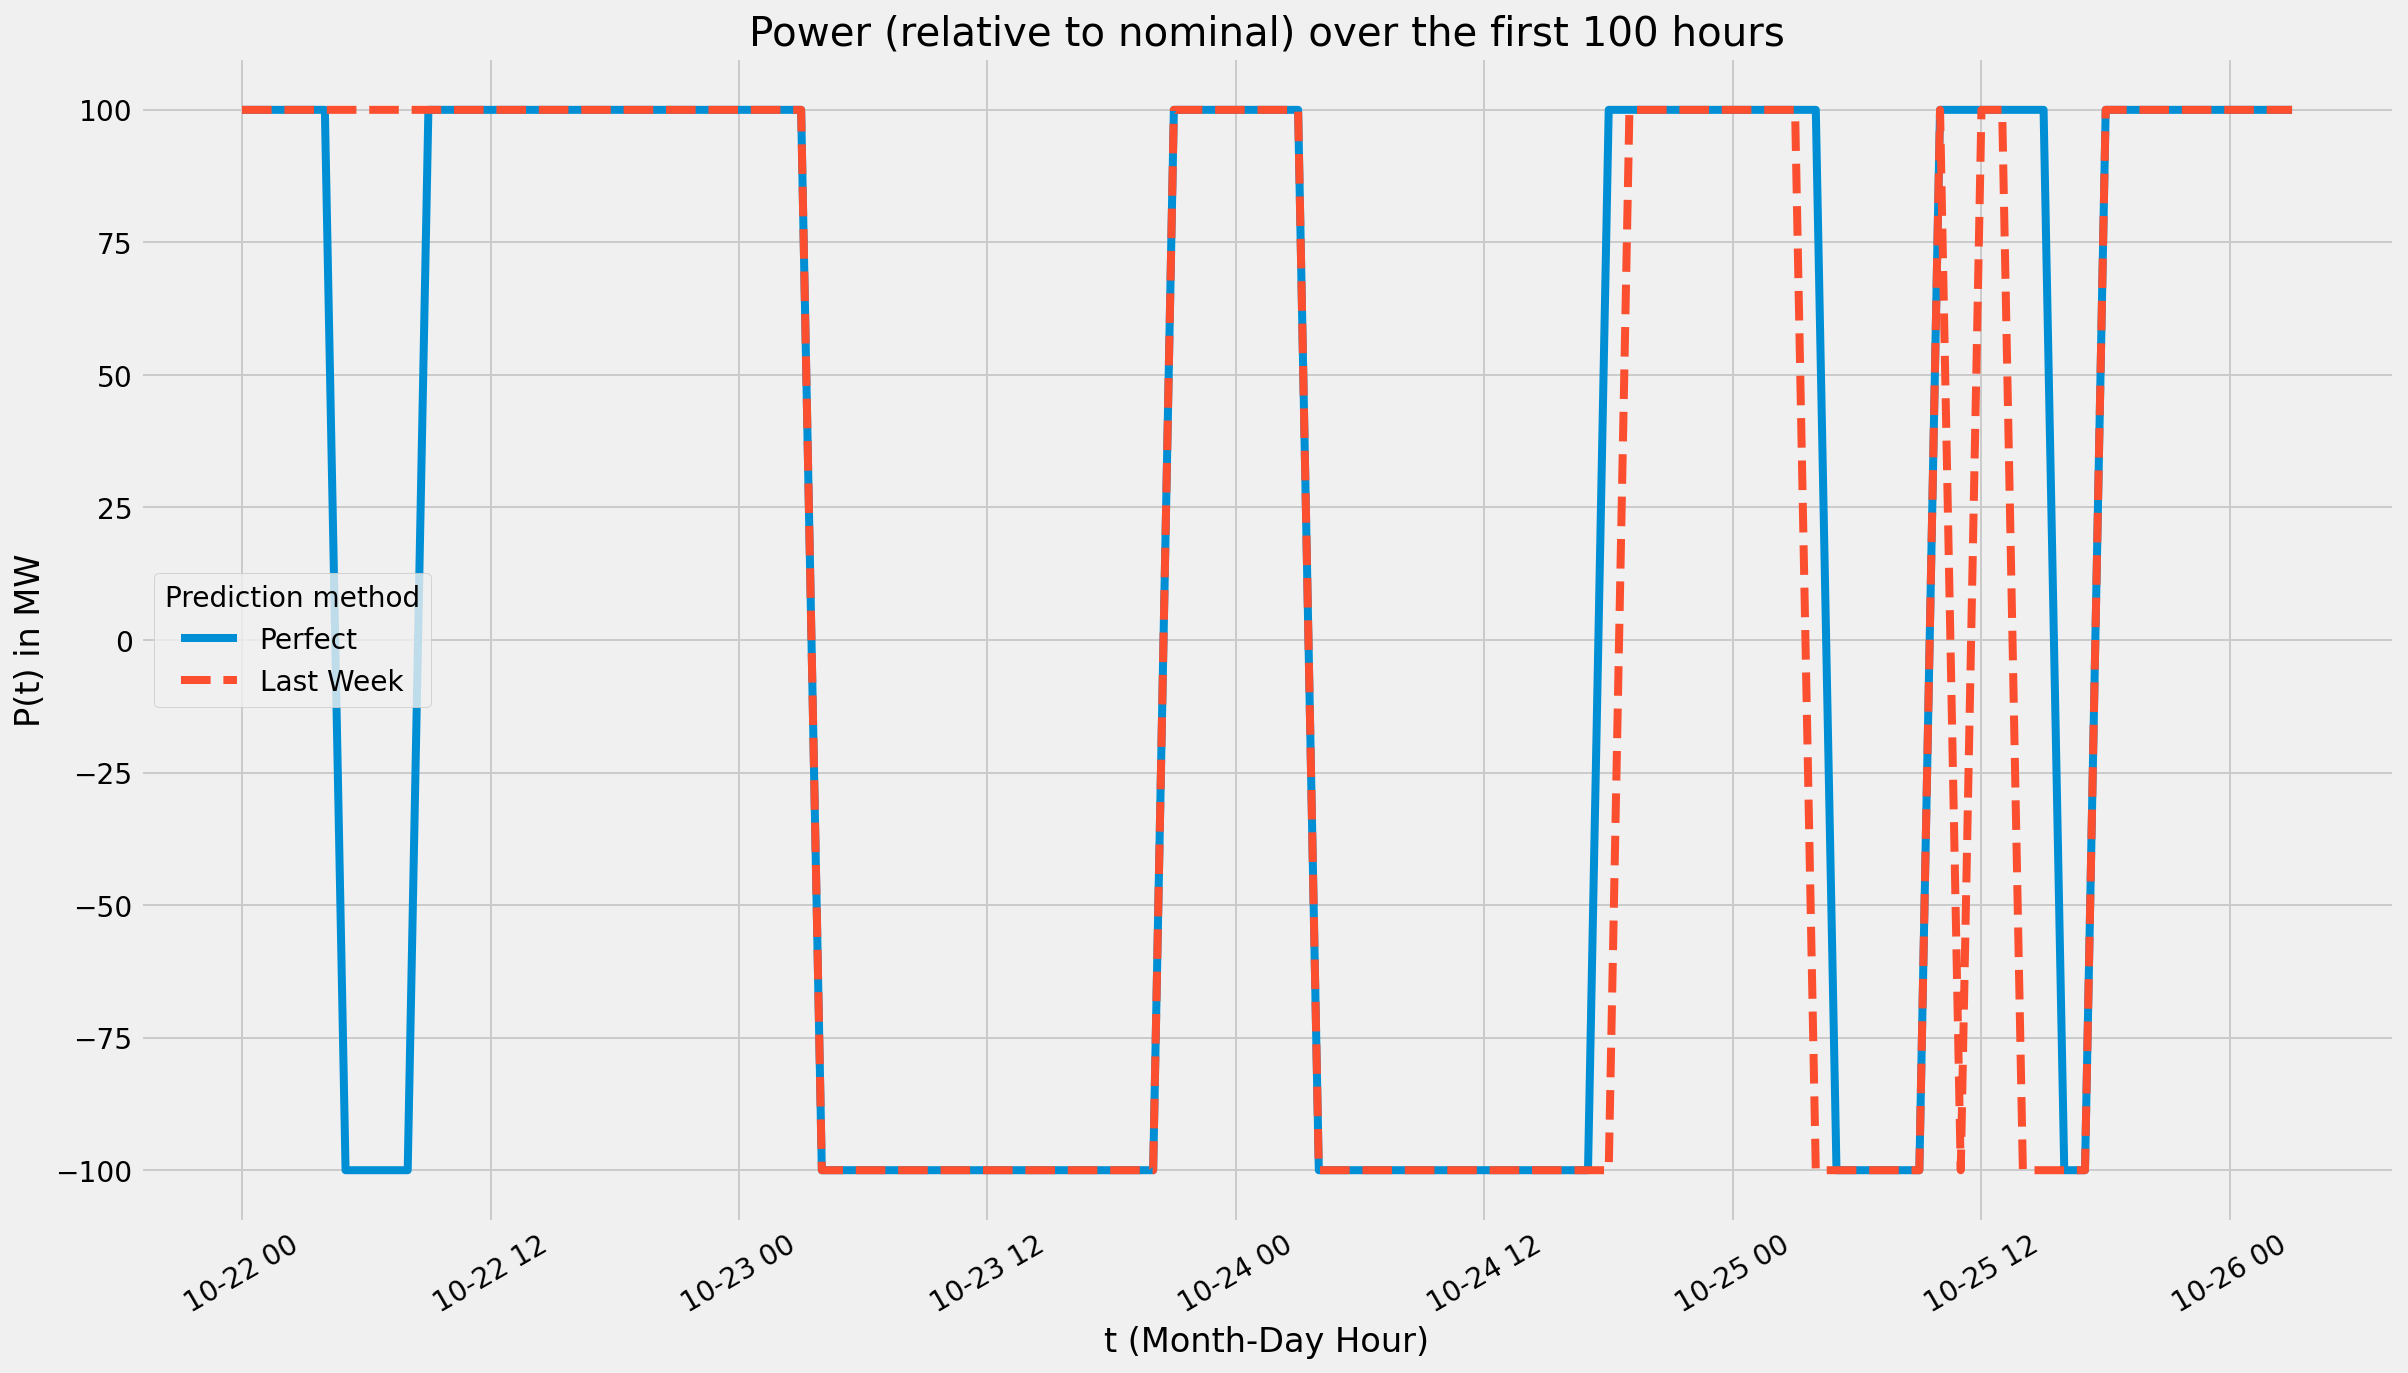

In [19]:
fig,ax=plt.subplots(figsize=(18,10))
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_title('Power (relative to nominal) over the first 100 hours')
ax.set(ylabel='P(t) in MW', xlabel='t (Month-Day Hour)')
ax = sns.lineplot(x="Datetime", y="Pt", data=results_perfect.head(100), label='Perfect')
ax = sns.lineplot(x="Datetime", y="Pt", data=results_lastWeek.head(100), linestyle='--', label='Last Week')
plt.legend(title='Prediction method', loc='center left')

#### Plot E(t) for the first 100 hours

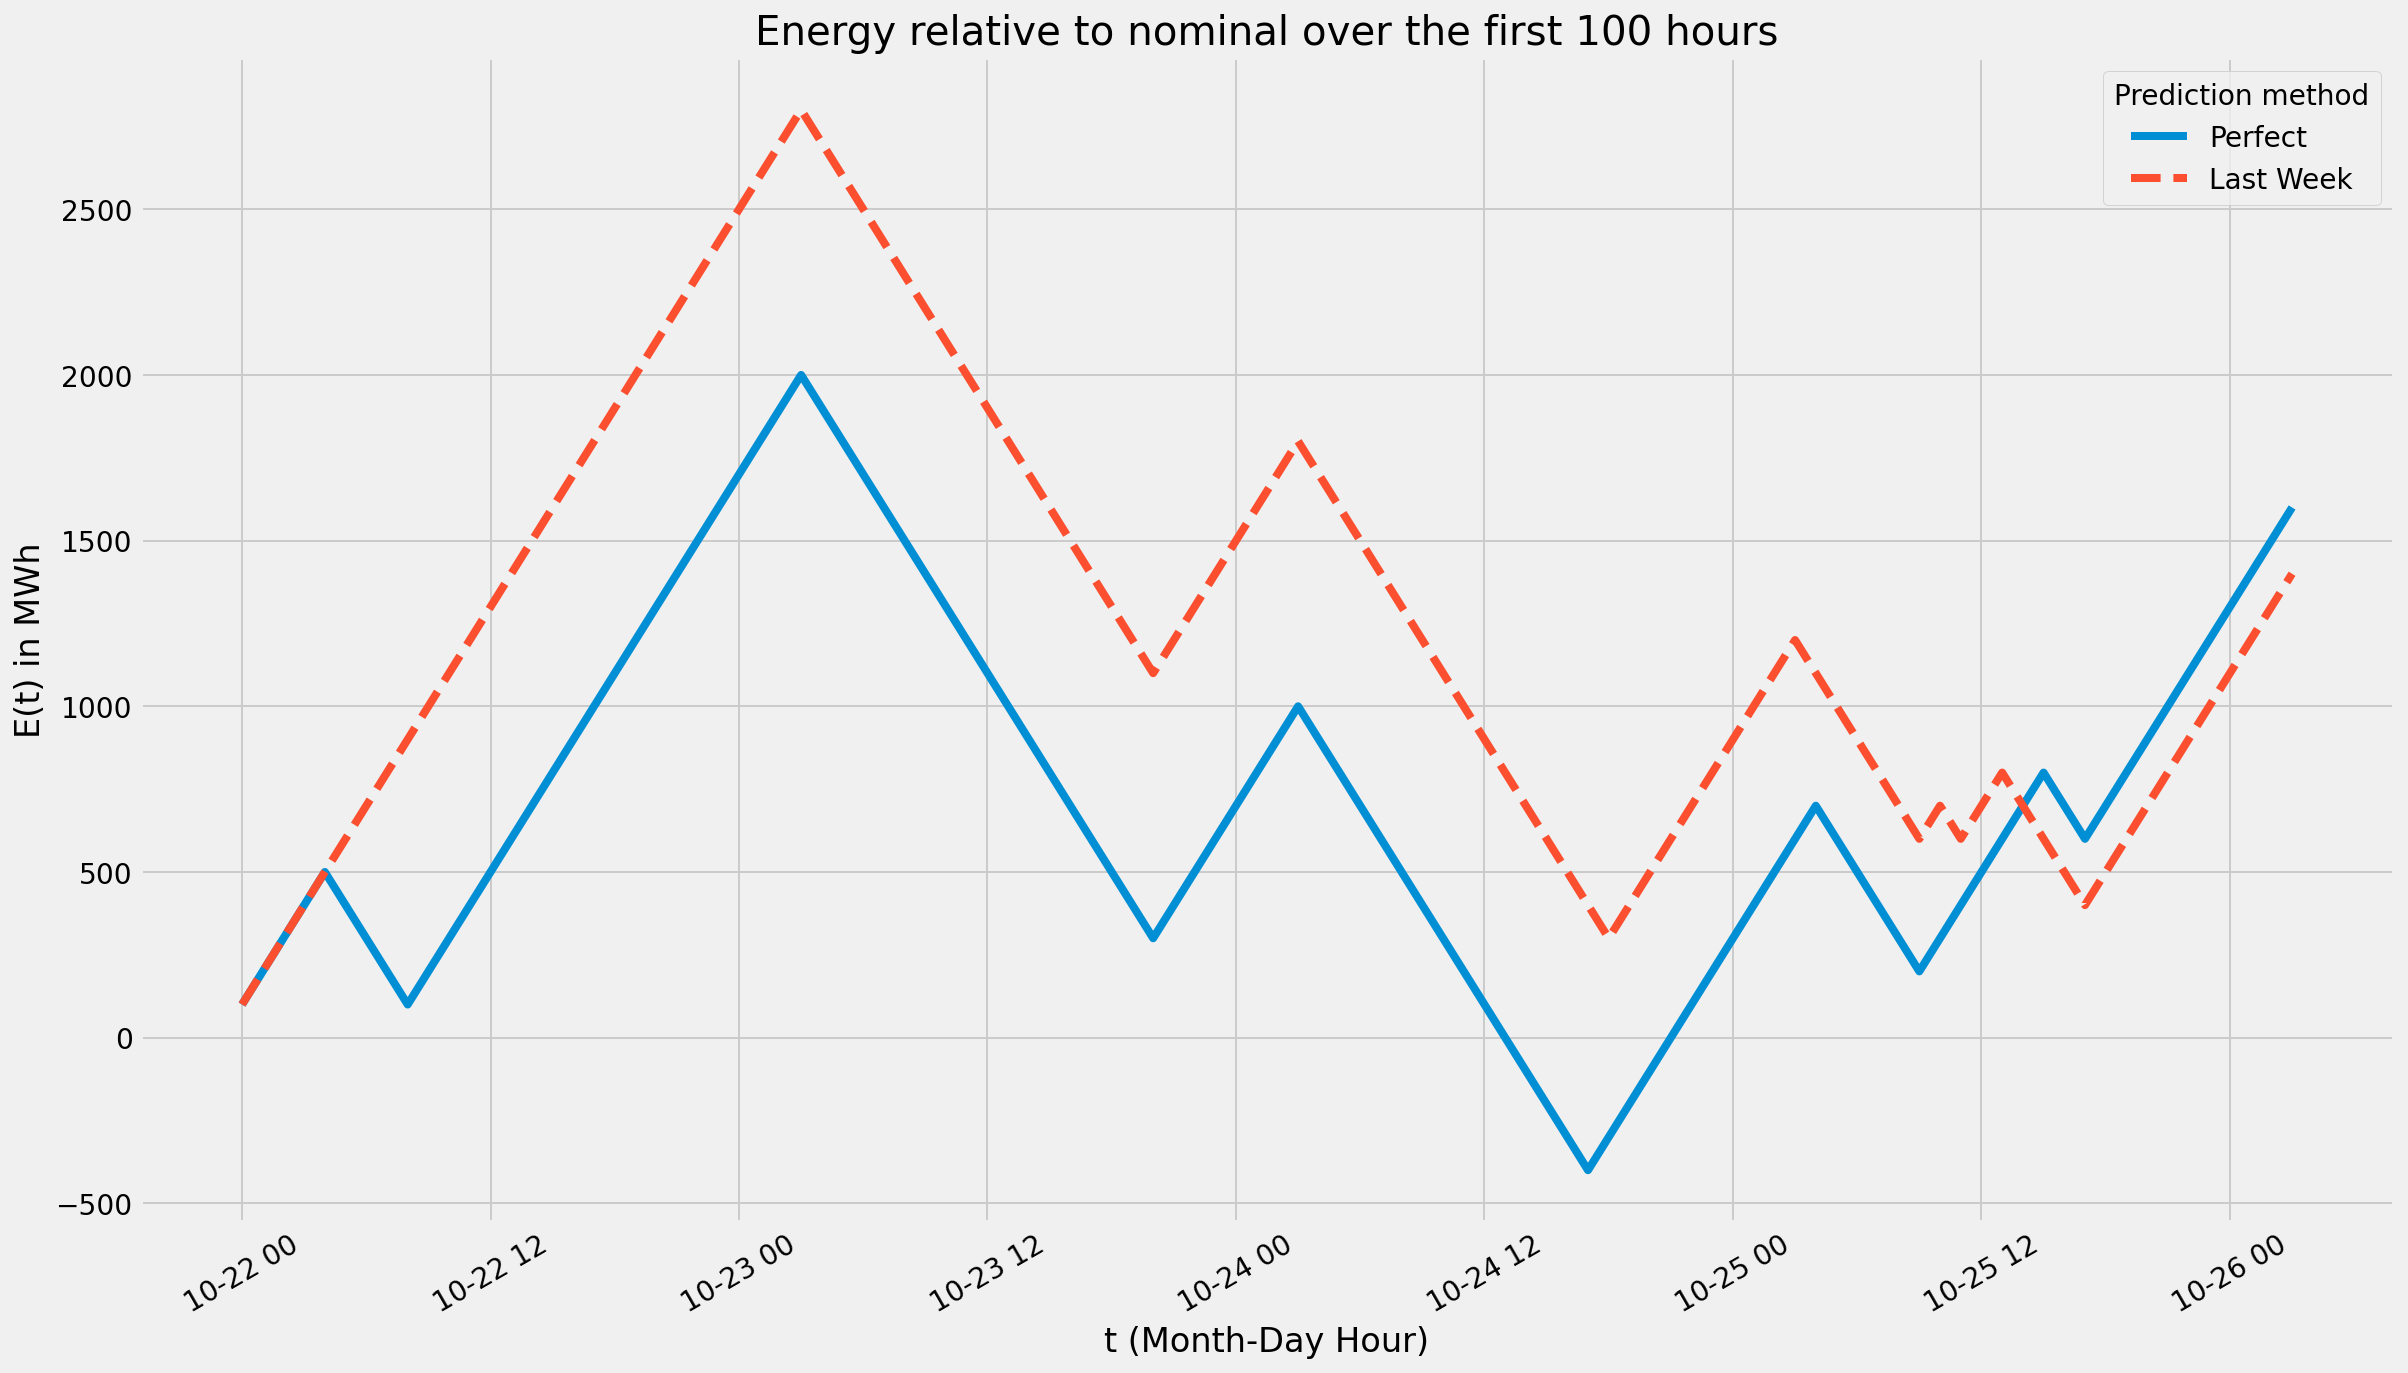

In [20]:
fig,ax=plt.subplots(figsize=(18,10))
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_title('Energy relative to nominal over the first 100 hours')
ax.set(ylabel='E(t) in MWh', xlabel='t (Month-Day Hour)')
ax = sns.lineplot(x="Datetime", y="Et", data=results_perfect.head(100), label='Perfect')
ax = sns.lineplot(x="Datetime", y="Et", data=results_lastWeek.head(100), linestyle='--', label='Last Week')
plt.legend(title='Prediction method', loc='upper right')

#### Plot earnings

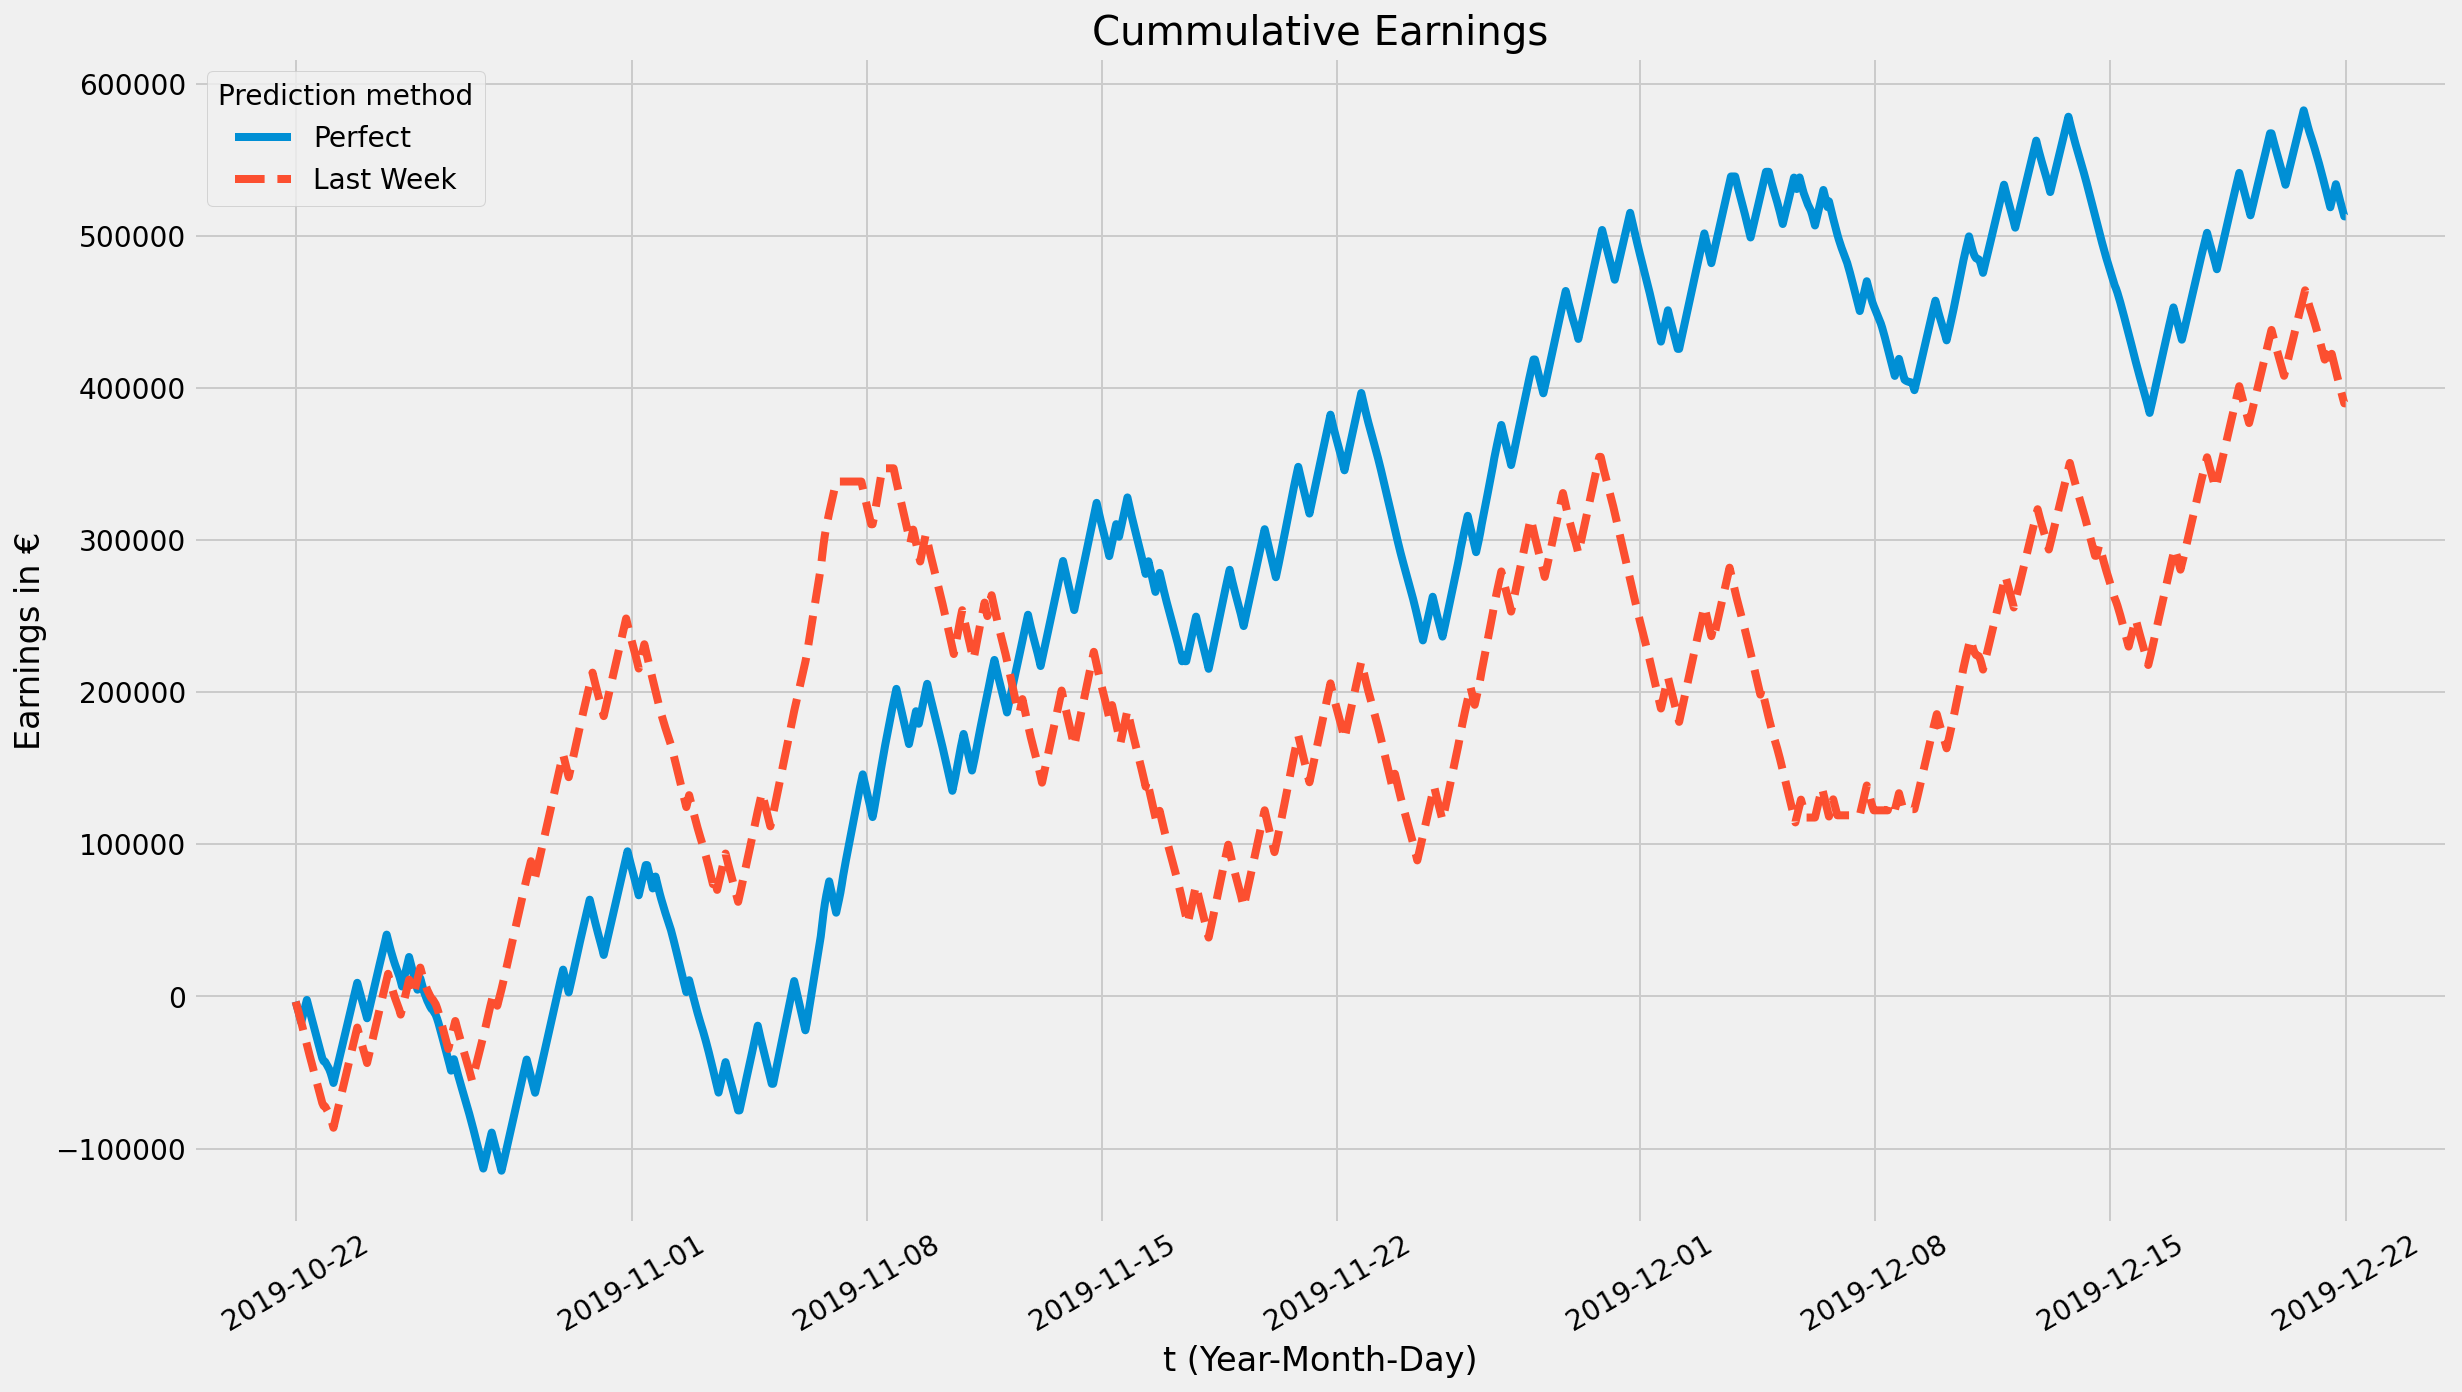

In [21]:
fig,ax=plt.subplots(figsize=(18,10))
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_title('Cummulative Earnings')
ax.set(ylabel='Earnings in €', xlabel='t (Year-Month-Day)')
ax = sns.lineplot(x="Datetime", y="cummulative_earnings", data=results_perfect, label='Perfect')
ax = sns.lineplot(x="Datetime", y="cummulative_earnings", data=results_lastWeek, linestyle='--', label='Last Week')
plt.legend(title='Prediction method', loc='upper left')

#### Average Power and electricity price for each hour of the day and each day of the week  
Please note that the second y axis is inverted. This is not a data viz course, so sue me

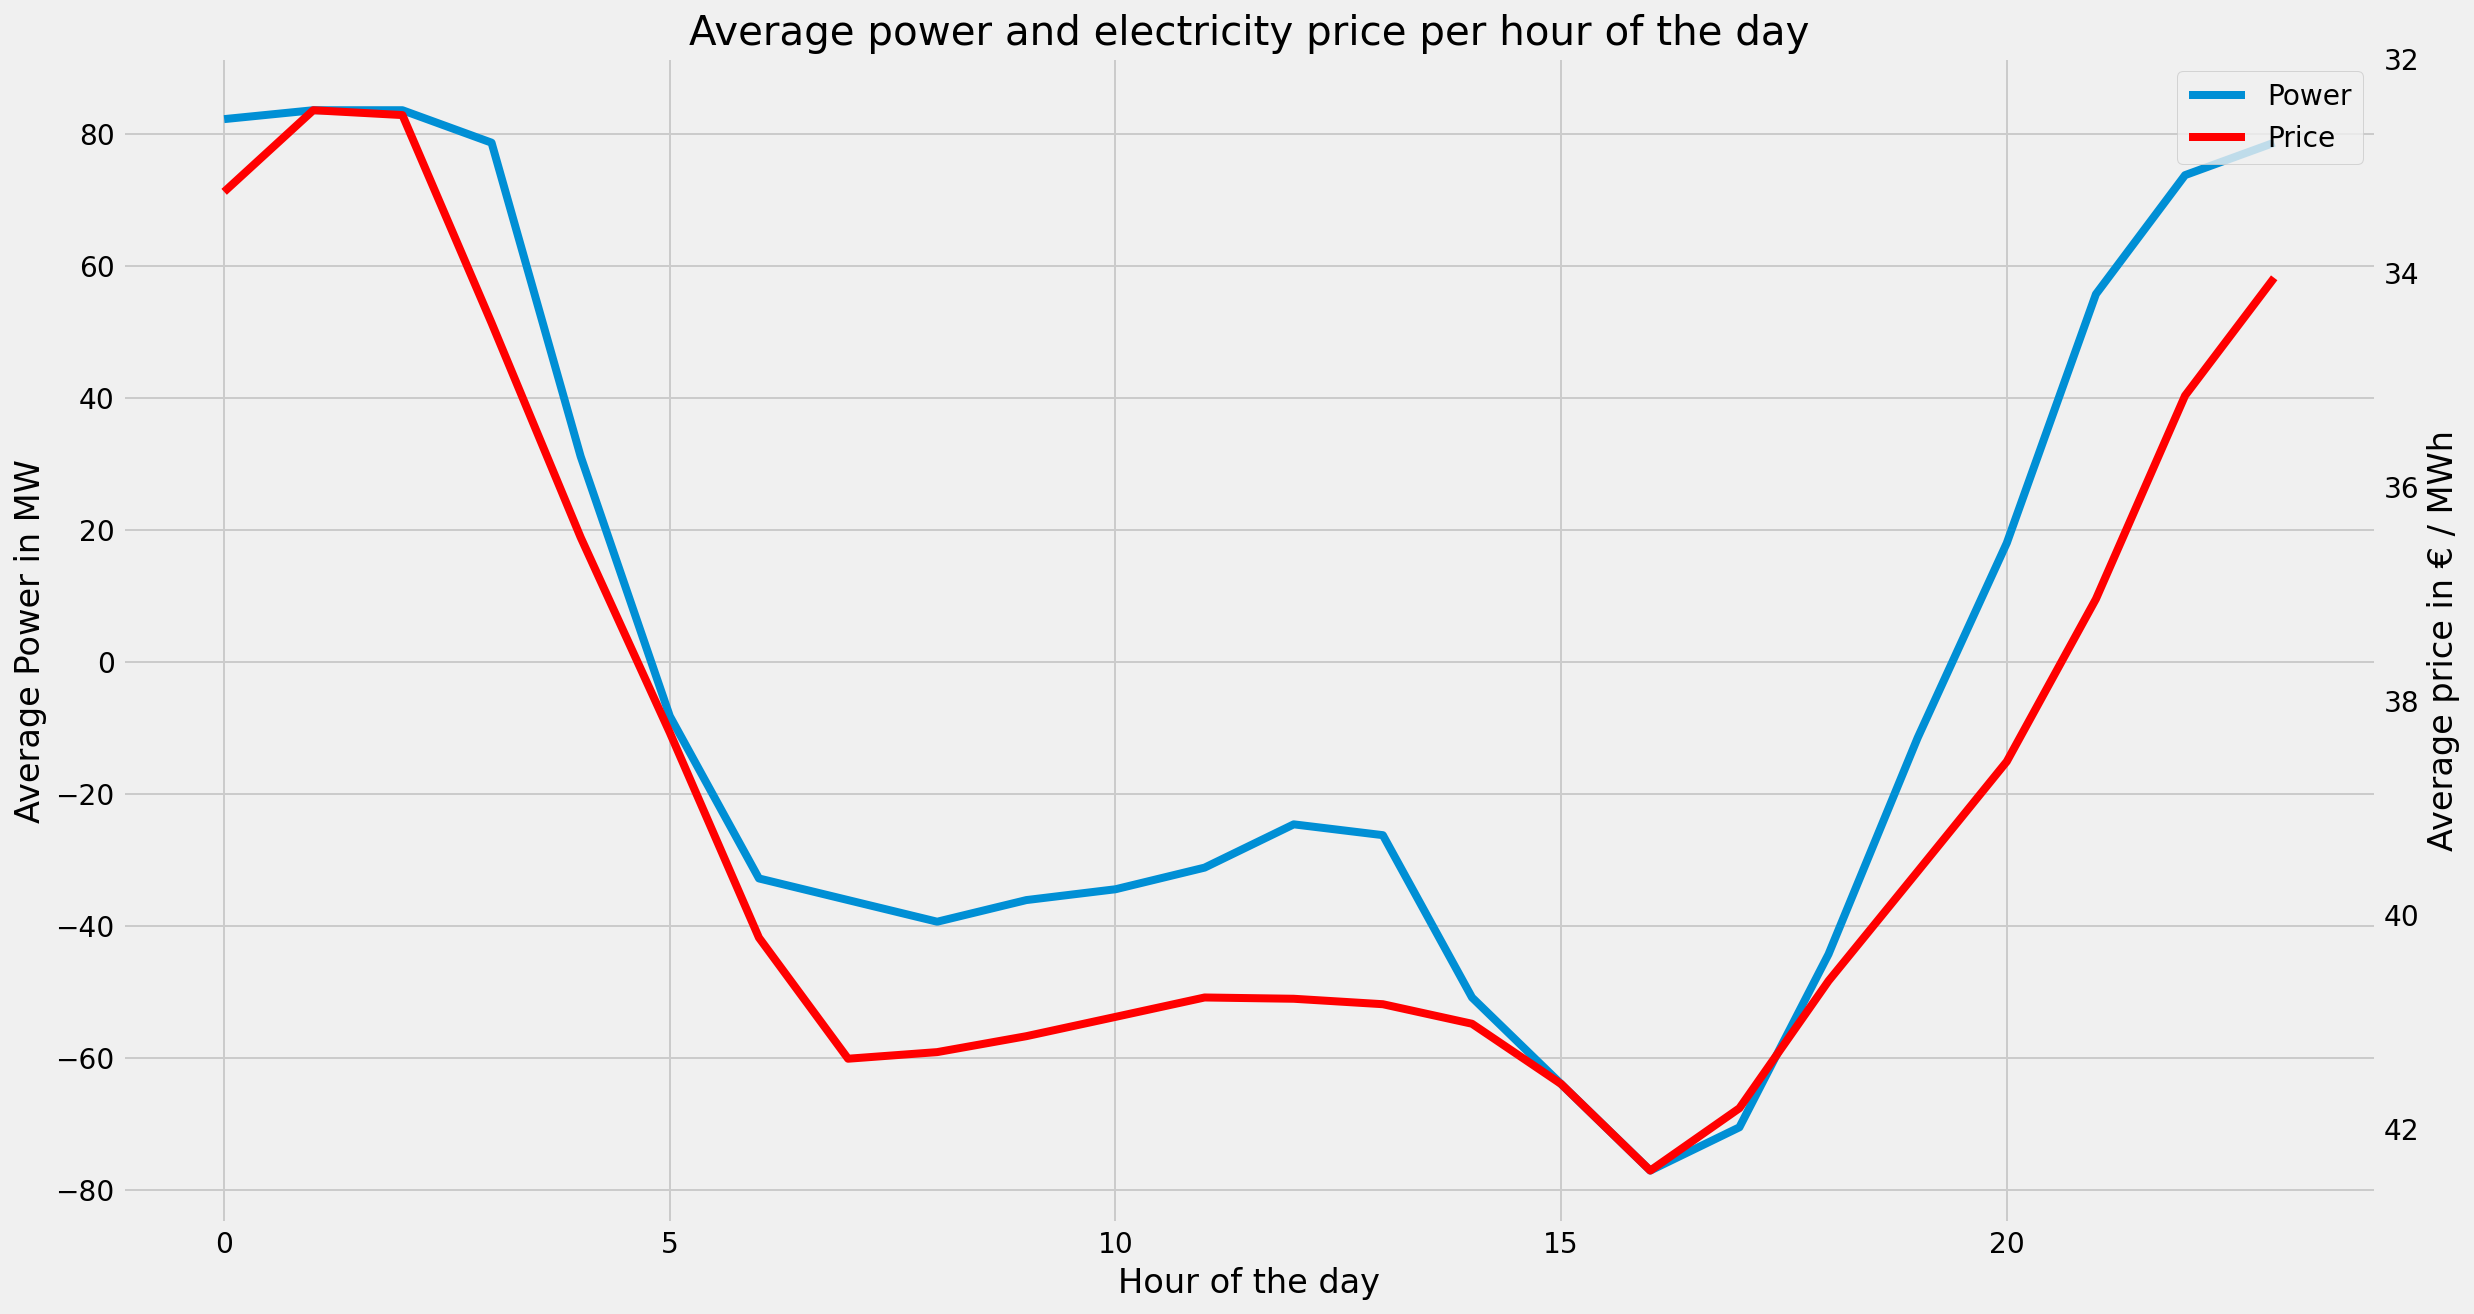

In [22]:
results_lastWeek_hours = results_lastWeek.groupby([results_lastWeek.index.hour]).mean()
fig,ax=plt.subplots(figsize=(18,10))
ax.set_title('Average power and electricity price per hour of the day')
ax.set(ylabel='Average Power in MW', xlabel='Hour of the day')
ax = sns.lineplot(x="Datetime", y="Pt", data=results_lastWeek_hours, label='Power')
ax2 = ax.twinx()
ax2.set_ylabel('Average price in € / MWh')
ax2 = sns.lineplot(x="Datetime", y="current_price", data=results_lastWeek_hours, color='red', label='Price')
ax2.invert_yaxis()
ax2.grid(False)
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend([],[], frameon=False)
plt.legend(lines, labels, loc='upper right')

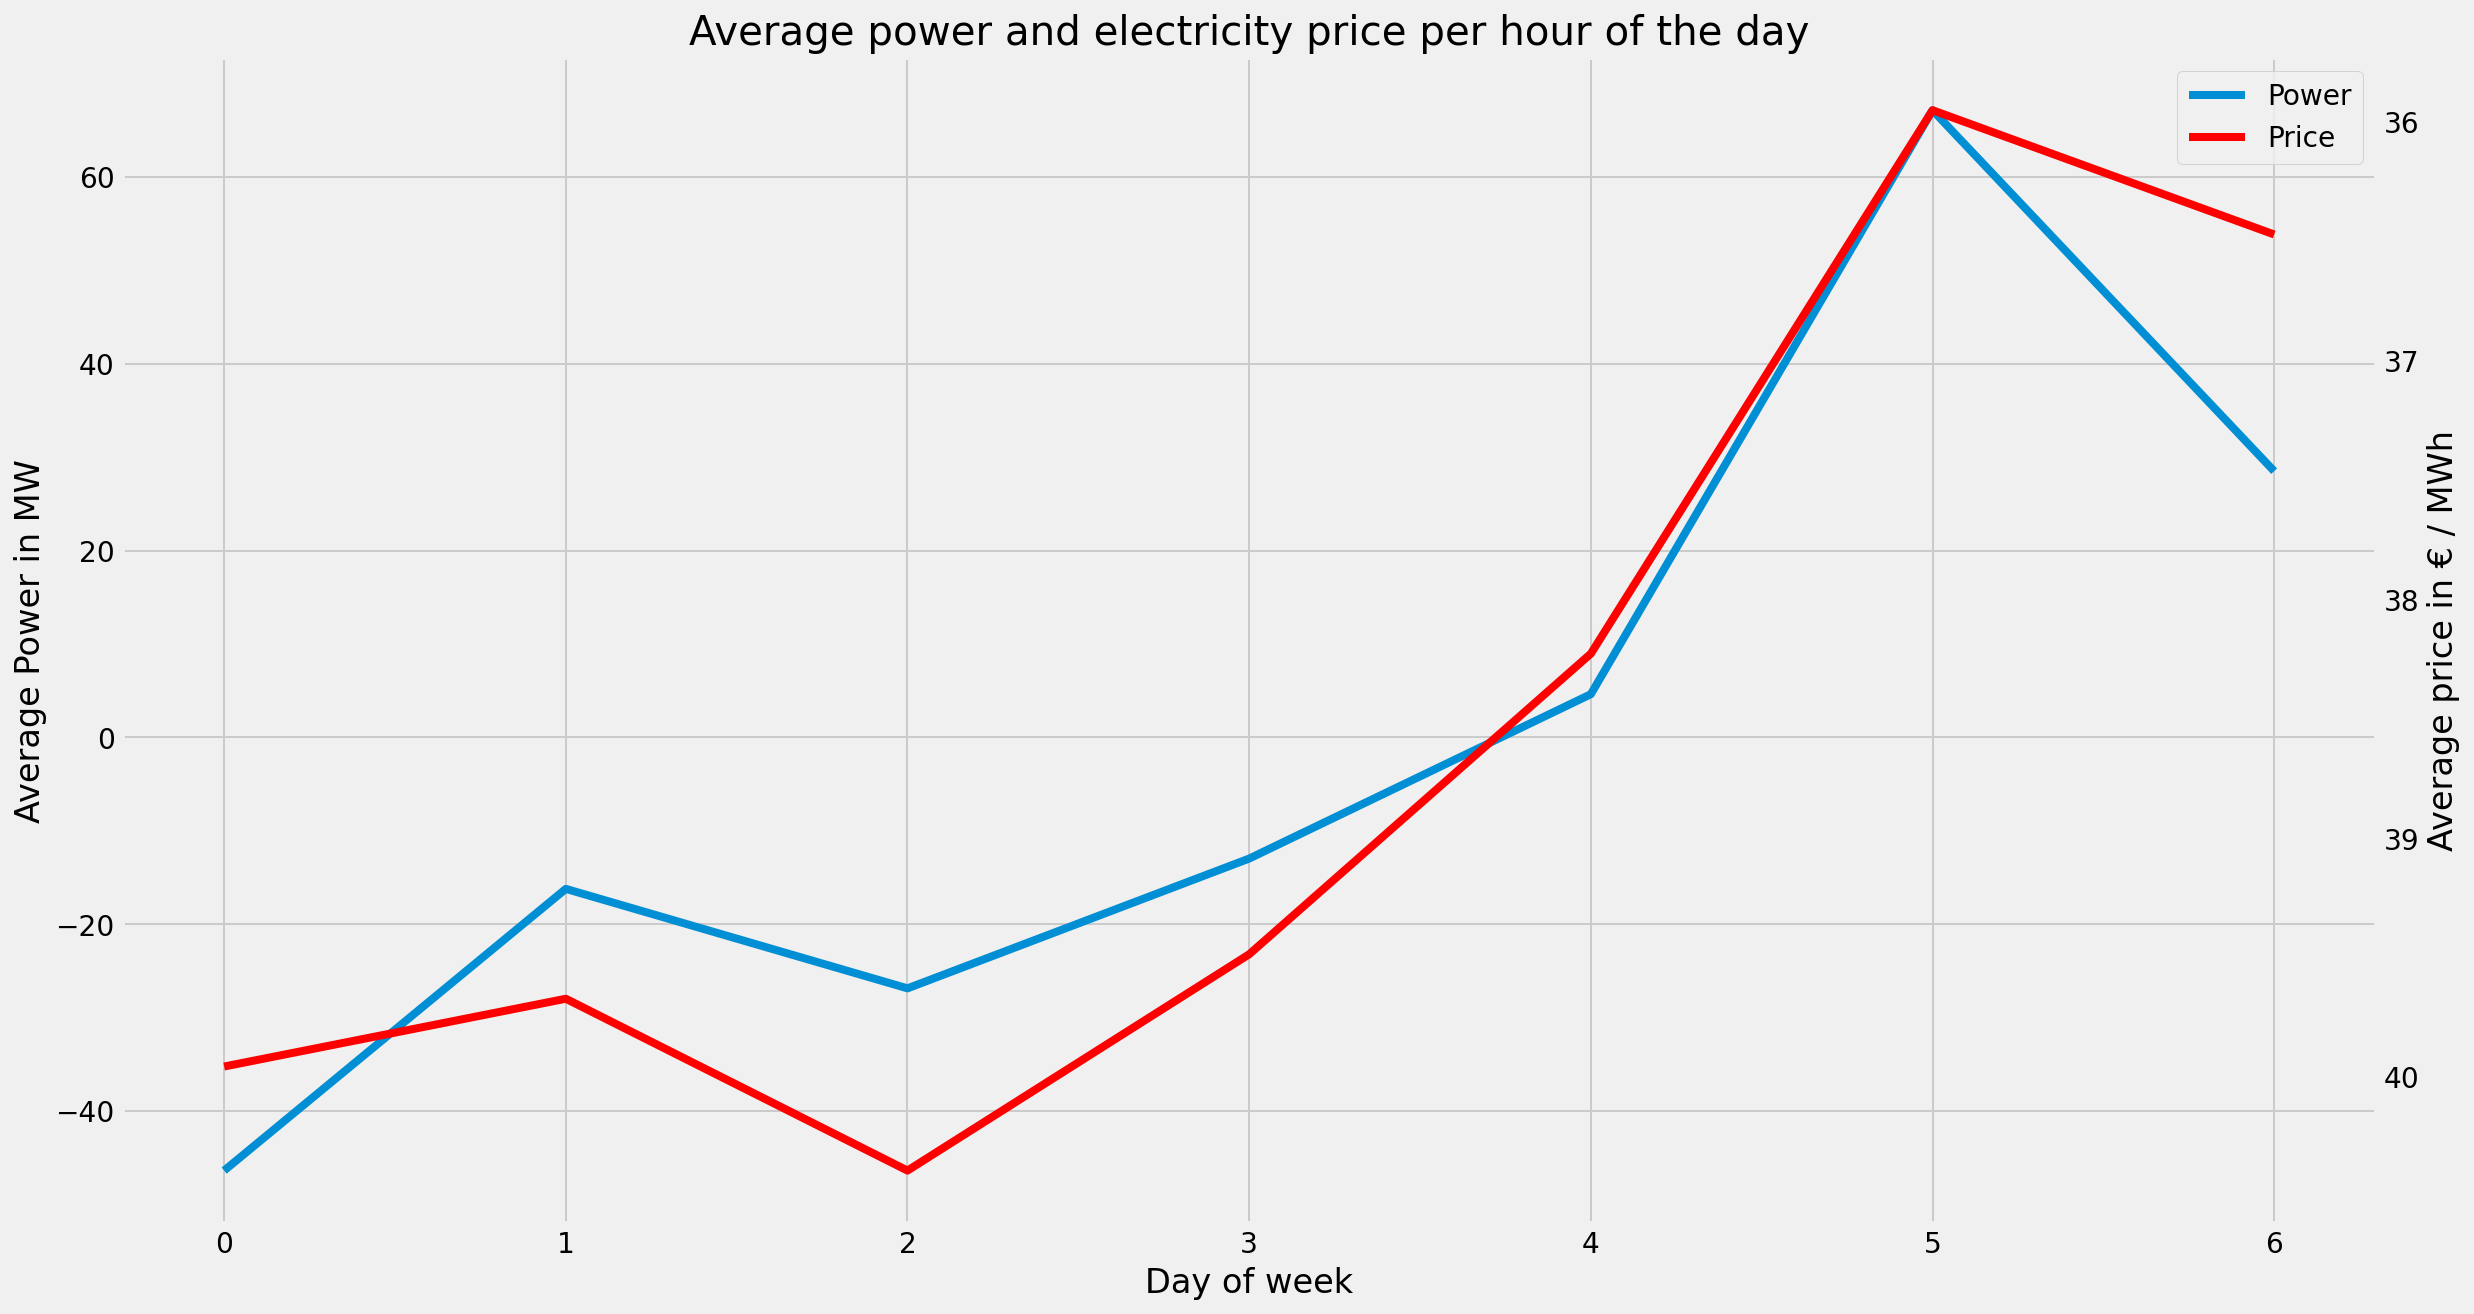

In [23]:
results_lastWeek_weekday = results_lastWeek.groupby([results_lastWeek.index.weekday]).mean()
fig,ax=plt.subplots(figsize=(18,10))
ax.set_title('Average power and electricity price per hour of the day')
ax.set(ylabel='Average Power in MW', xlabel='Day of week')
ax = sns.lineplot(x="Datetime", y="Pt", data=results_lastWeek_weekday, label='Power')
ax2 = ax.twinx()
ax2.set_ylabel('Average price in € / MWh')
ax2 = sns.lineplot(x="Datetime", y="current_price", data=results_lastWeek_weekday, color='red', label='Price')
ax2.invert_yaxis()
ax2.grid(False)
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax.legend([],[], frameon=False)
plt.legend(lines, labels, loc='upper right')

#### Plot actual E(t) for the first week versus E(t) from first iteration of optimization

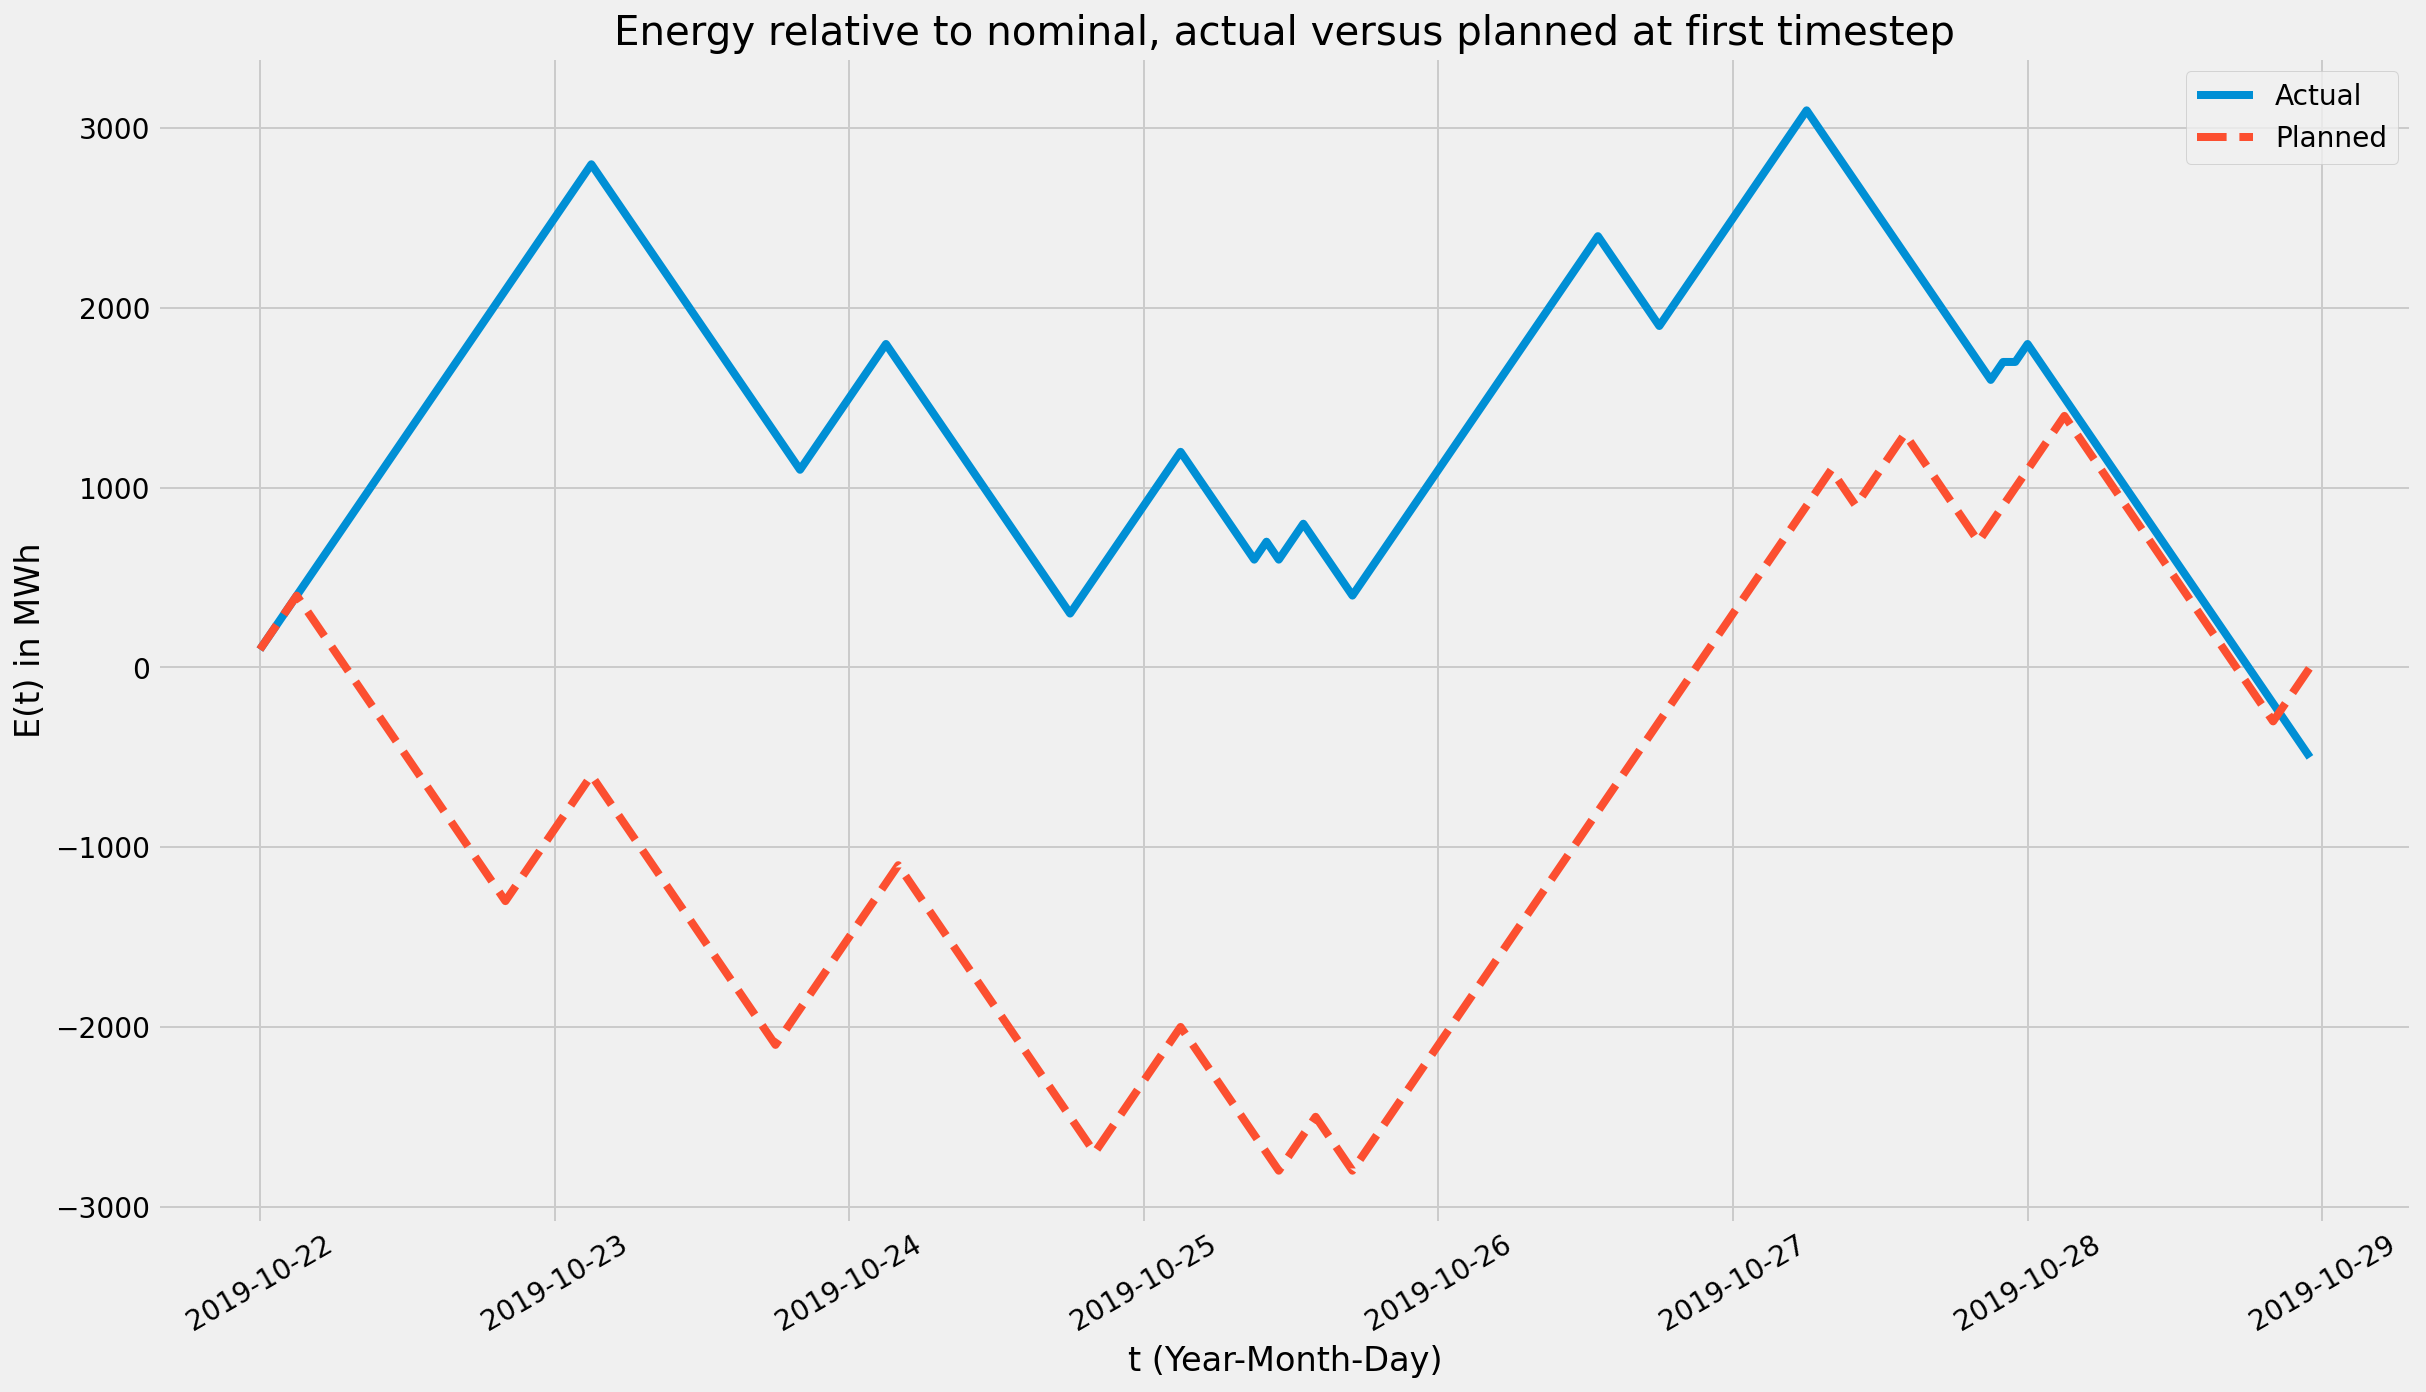

In [24]:
fig,ax=plt.subplots(figsize=(18,10))
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_title('Energy relative to nominal, actual versus planned at first timestep')
ax.set(ylabel='E(t) in MWh', xlabel='t (Year-Month-Day)')
ax = sns.lineplot(x="Datetime", y="Et", data=results_lastWeek.head(24*7), label='Actual')
ax = sns.lineplot(x="Datetime", y="Et_first", data=results_lastWeek.head(24*7), linestyle='--', label='Planned')
plt.legend(loc='upper right')